# Predicting Air Delays
Notebook II: Exploratory Data Analysis (EDA) & Feature Engineering
----

Thank you for your review of my code notebook.
This notebook's goal is to analyze and prepare the dataset for exposure on a Machine Learning algorithm.

---
#### Problem Statement: 
Both travelers and airlines find delays frustrating and costly. This project attempts to be able to predict the probability of a commercial flight delay for any flight in the United States.

---

#### MVP:
My product will be a small lightweight application run on `streamlit` platform for proof-of-concept where a user can find the probability of their desired flight having a delay, how long the delay may be, and how much will the delay cost the user in _lost time_ at the destination.

Since we have labels on all our data, the model the app will be based on is a supervised multi-class classification machine learning model.

---
# EDA 

The primary challenge in this notebook is making sense of what will matter to a machine learning algorithm. At the end of this notebook will will have a final processed set of data to work our models on. 

The notebook is structured as follows.<br> 
**Notebook II: EDA and Preprocessing **
>1. Setup/Imports
>2. Load data
>3. EDA
>4. Feature engineering and selection. 
>5. Save the final CSV and discuss next steps. 

The processed dataframe will be saved on a new file by the end of this notebook and called into the subsequent notebook EDA for readability.

The notebooks in this project are: <br>
I. Intake and cleaning<br>
**II. EDA and preprocessing**<br>
III. Modeling and predictions<br>
IV. App<br>

---

## 1. Library imports
----
Load our analytical libraries and load our previously saved dataset. 


In [1]:
import os 
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns', None)

## 2. Load Dataset
---


In [3]:
flights = pd.read_csv('../Data/sample_cleaned.csv')

In [4]:
flights.shape

(174362, 26)

In [5]:
flights.isnull().sum()

year                   0
month                  0
day_of_month           0
day_of_week            0
fl_date                0
airline                0
tail_num               0
op_carrier_fl_num      0
origin                 0
origin_city_name       0
dest                   0
dest_city_name         0
crs_dep_time           0
dep_time               0
dep_delay              0
crs_arr_time           0
arr_time               0
arr_delay              0
cancelled              0
cancellation_code      0
distance               0
carrier_delay          0
weather_delay          0
nas_delay              0
security_delay         0
late_aircraft_delay    0
dtype: int64

## 3. Exploratory Data Analysis:
---
This section of the notebook deals with data explorations. 

Our working definition of a **_delay_** is a flight arriving at the destination airport 15 minute after their scheduled arrival. This also means that we consider an on-time arrival is **any arrival that is within 15 minutes of it's scheduled arrival time**. This is the same definition that reporting airlines are required to adopt according to the the Department of Transportation. 

`'arr_delay'` is our target variable. 


In [6]:
flights.head(3)

,year,month,day_of_month,day_of_week,fl_date,airline,tail_num,op_carrier_fl_num,origin,origin_city_name,dest,dest_city_name,crs_dep_time,dep_time,dep_delay,crs_arr_time,arr_time,arr_delay,cancelled,cancellation_code,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2018,Apr,21,Sat,2018-04-21,American Airlines,N199UW,1929,PHL,"Philadelphia, PA",BOS,"Boston, MA",2030,2058.0,28.0,2151,2213.0,22.0,0.0,completed_flight,280.0,22.0,0.0,0.0,0.0,0.0
1,2021,Jul,7,Wed,2021-07-07,Skywest Airlines,N746SK,3179,SAF,"Santa Fe, NM",DFW,"Dallas/Fort Worth, TX",1035,1406.0,211.0,1326,1643.0,197.0,0.0,completed_flight,551.0,0.0,0.0,0.0,0.0,197.0
2,2018,Nov,27,Tue,2018-11-27,Envoy Air,N616AE,3630,MIA,"Miami, FL",CLE,"Cleveland, OH",2130,2136.0,6.0,35,101.0,26.0,0.0,completed_flight,1080.0,0.0,6.0,20.0,0.0,0.0


### EDA: Delay class balance
---
First look at the balance of classes. 

In [7]:
delayed = flights[flights['arr_delay'] > 15]
delayed.shape[0]

84936

In [8]:
ontime = flights[flights['arr_delay']==0]
ontime.shape[0]

85786

In [9]:
print(f'The balance of delayed to on-time flights is: {round(delayed.shape[0]/ontime.shape[0], 3)}')

The balance of delayed to on-time flights is: 0.99


The ratio of delayed to on-time is nearly even. That is, it is nearly 1. 
We have approximately 1.4 million examples of both on-time flights, those of delayed flights. 

In [10]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174362 entries, 0 to 174361
Data columns (total 26 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   year                 174362 non-null  int64  
 1   month                174362 non-null  object 
 2   day_of_month         174362 non-null  int64  
 3   day_of_week          174362 non-null  object 
 4   fl_date              174362 non-null  object 
 5   airline              174362 non-null  object 
 6   tail_num             174362 non-null  object 
 7   op_carrier_fl_num    174362 non-null  int64  
 8   origin               174362 non-null  object 
 9   origin_city_name     174362 non-null  object 
 10  dest                 174362 non-null  object 
 11  dest_city_name       174362 non-null  object 
 12  crs_dep_time         174362 non-null  int64  
 13  dep_time             174362 non-null  float64
 14  dep_delay            174362 non-null  float64
 15  crs_arr_time     

### EDA: Categorical column datatypes.
---
Pandas infers the data types on import to our workspace. The following will convert a few of our categorical data values from numbers to strings to ease the EDA process.

In [11]:
categorical = {'year' : str, 'month' : str, 'day_of_month': str, 'day_of_week': str, 'tail_num': str,
              'op_carrier_fl_num': str, 'crs_dep_time': str, 'dep_time' : str, 'crs_arr_time': str, 'arr_time' : str}

In [12]:
flights = flights.astype(categorical).copy()

In [13]:
flights.describe()

,dep_delay,arr_delay,cancelled,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
count,174362.000000,174362.000000,174362.000000,174362.000000,174362.000000,174362.000000,174362.000000,174362.000000,174362.000000
mean,30.794560,32.174419,0.020876,833.075659,10.477380,1.852921,7.326665,0.065674,12.472655
std,67.590764,66.866606,0.142970,601.093100,45.017009,20.987294,24.671435,2.846218,37.699340
min,-1.000000,-1.000000,0.000000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,388.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,678.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,39.000000,39.000000,0.000000,1069.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1884.000000,1868.000000,1.000000,5095.000000,1868.000000,1302.000000,1130.000000,738.000000,1279.000000


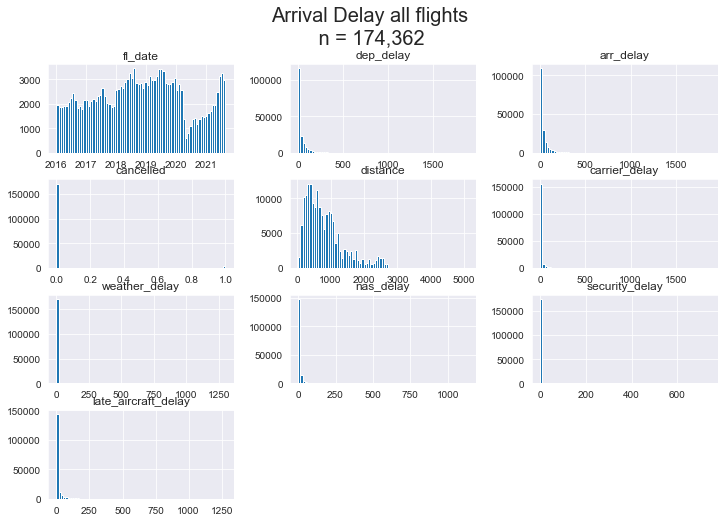

In [25]:
sns.set_style('darkgrid')
flights.hist(bins = 75, figsize = (12,8));
plt.suptitle(f'Arrival Delay all flights \n n = {flights.shape[0] :,} ', size = 20);
plt.savefig("../Assets/overall_delays_hist_log.pdf", bbox_inches="tight")

Not very useful since the most of our data lives in the first few buckets.
Note, all but one chart are in the minutes scale. The `distance` feature is in statute miles. 

Finally lets get the `fl_date` column into a date time format.

In [16]:
flights['fl_date'] = pd.to_datetime(flights['fl_date'])

In [17]:
flights.dtypes

year                           object
month                          object
day_of_month                   object
day_of_week                    object
fl_date                datetime64[ns]
airline                        object
tail_num                       object
op_carrier_fl_num              object
origin                         object
origin_city_name               object
dest                           object
dest_city_name                 object
crs_dep_time                   object
dep_time                       object
dep_delay                     float64
crs_arr_time                   object
arr_time                       object
arr_delay                     float64
cancelled                     float64
cancellation_code              object
distance                      float64
carrier_delay                 float64
weather_delay                 float64
nas_delay                     float64
security_delay                float64
late_aircraft_delay           float64
dtype: objec

### EDA: Distribution of all delayed flights
---
Taking a first level view of all flights in the sample with positive values in `arrival_delay` column. 

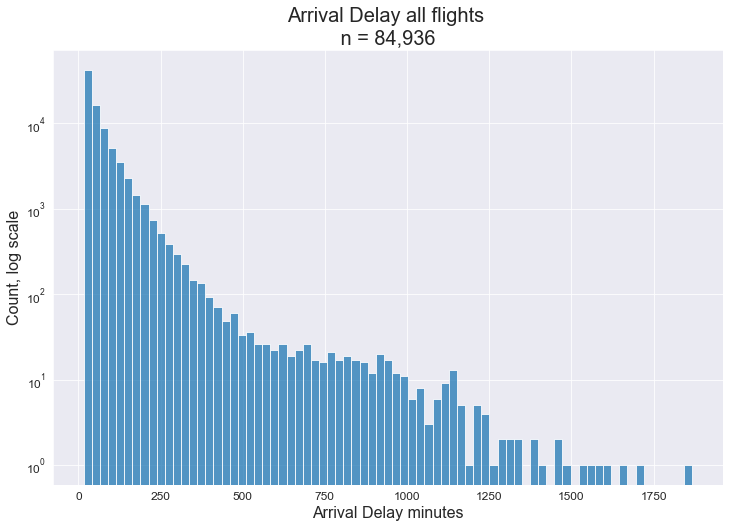

In [26]:
plt.figure(figsize = (12,8));
sns.set_style('darkgrid')
sns.histplot(delayed['arr_delay'], bins = 75);
plt.yscale('log')
plt.title(f'Arrival Delay all flights \n n = {delayed.shape[0] :,} ', size = 20);
plt.xlabel('Arrival Delay minutes', size=16);
plt.xticks(fontsize = 12);
plt.ylabel('Count, log scale', size= 16);
plt.yticks(fontsize = 12);
plt.savefig("../Assets/delays_hist_log.pdf", bbox_inches="tight")

The tail of this chart shows delay times that are in the thousands of minutes. A 24 hour period has 1,440 minutes. granted most of data is well below, we still have troubling occurrences of extremely long delays. <br>
I will dissect the dateset into 4-hour chunks and look at the counts of delays

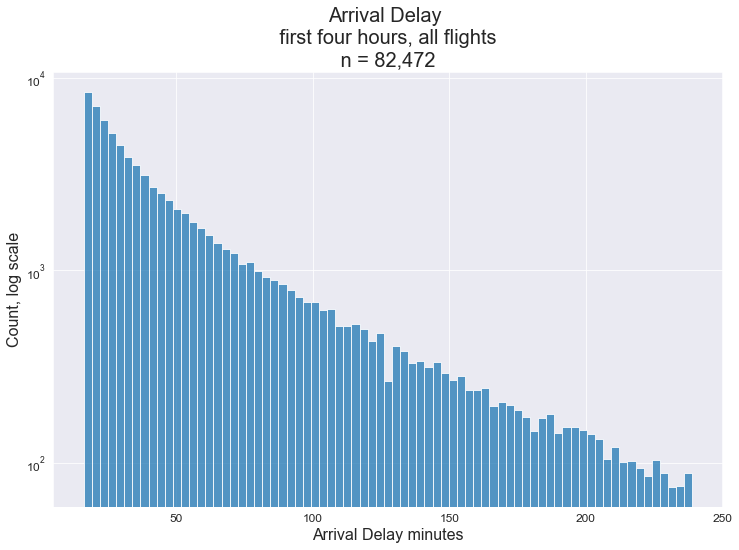

In [27]:
plt.figure(figsize = (12,8));
sns.set_style('darkgrid')
sns.histplot(delayed[delayed['arr_delay'] < 240]['arr_delay'], bins = 75);
plt.yscale('log')
plt.title(f'Arrival Delay \n first four hours, all flights \n n = {delayed[delayed["arr_delay"] < 240].shape[0] :,} ', size = 20);
plt.xlabel('Arrival Delay minutes', size=16);
plt.xticks(fontsize = 12);
plt.ylabel('Count, log scale', size= 16);
plt.yticks(fontsize = 12);
plt.savefig("../Assets/first_four_hours_delays_hist_log.pdf", bbox_inches="tight")

Since the value of `n` has not reduced by much, we can state that all but 40,000 flights that had delays were mostly 'short' delays. This indicates that most flight delays are four hours or less.

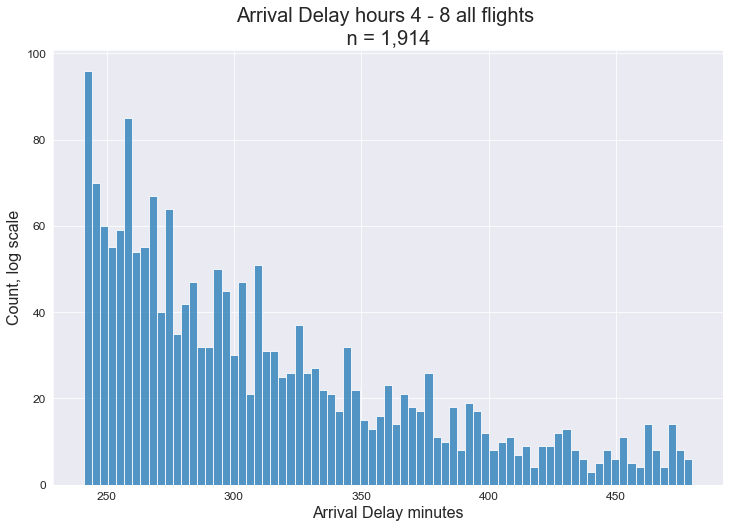

In [28]:
plt.figure(figsize = (12,8));
sns.set_style('darkgrid')
sns.histplot(delayed[(delayed['arr_delay'] > 240) & (delayed['arr_delay']<=480)]['arr_delay'], bins = 75);
#plt.yscale('log')
plt.title(f'Arrival Delay hours 4 - 8 all flights \n n = {delayed[(delayed["arr_delay"] > 240) & (delayed["arr_delay"]<=480)].shape[0] :,} ', size = 20);
plt.xlabel('Arrival Delay minutes', size=16);
plt.xticks(fontsize = 12);
plt.ylabel('Count, log scale', size= 16);
plt.yticks(fontsize = 12);
plt.savefig("../Assets/hours_4-8_delays_hist_log.pdf", bbox_inches="tight")

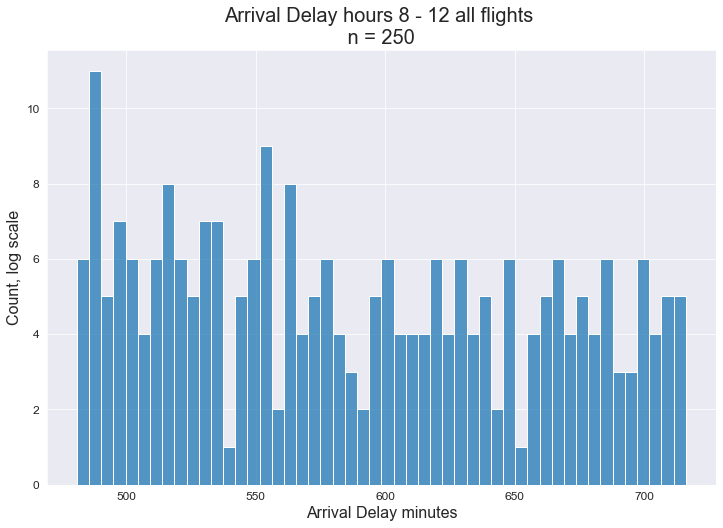

In [29]:
plt.figure(figsize = (12,8));
sns.set_style('darkgrid')
sns.histplot(delayed[(delayed['arr_delay'] > 480) & (delayed['arr_delay']<=720)]['arr_delay'], bins = 50);
#plt.yscale('log')
plt.title(f'Arrival Delay hours 8 - 12 all flights \n n = {delayed[(delayed["arr_delay"] > 480) & (delayed["arr_delay"]<=720)].shape[0] :,} ', size = 20);
plt.xlabel('Arrival Delay minutes', size=16);
plt.xticks(fontsize = 12);
plt.ylabel('Count, log scale', size= 16);
plt.yticks(fontsize = 12);
plt.savefig("../Assets/hours_8-12_delays_hist_log.pdf", bbox_inches="tight")

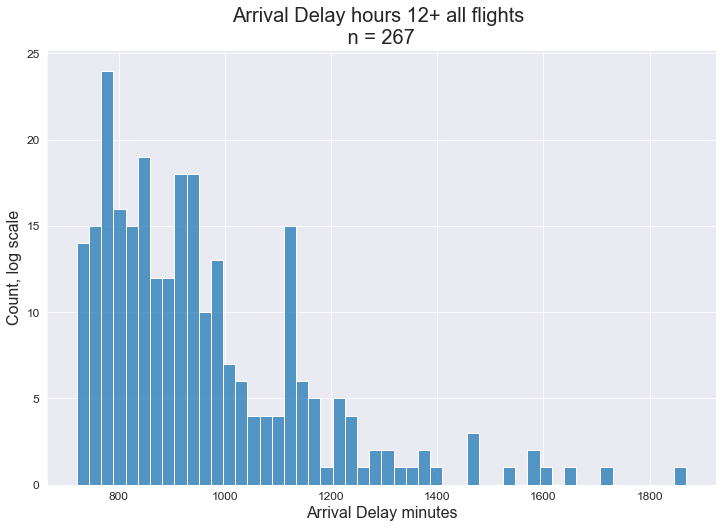

In [30]:
plt.figure(figsize = (12,8));
sns.set_style('darkgrid')
sns.histplot(delayed[delayed['arr_delay']>720]['arr_delay'], bins = 50);
#plt.yscale('log')
plt.title(f'Arrival Delay hours 12+ all flights \n n = {delayed[delayed["arr_delay"]> 720].shape[0] :,} ', size = 20);
plt.xlabel('Arrival Delay minutes', size=16);
plt.xticks(fontsize = 12);
plt.ylabel('Count, log scale', size= 16);
plt.yticks(fontsize = 12);
plt.savefig("../Assets/12+_delays_hist_log.pdf", bbox_inches="tight")

### EDA: `fl_date`
---
This column contains a _string_ that should be converted to a date-time object to make further analysis available. 

In [31]:
delayed = flights[flights['arr_delay']>=15].set_index('fl_date')

In [32]:
mean_delay = delayed['arr_delay'].mean()

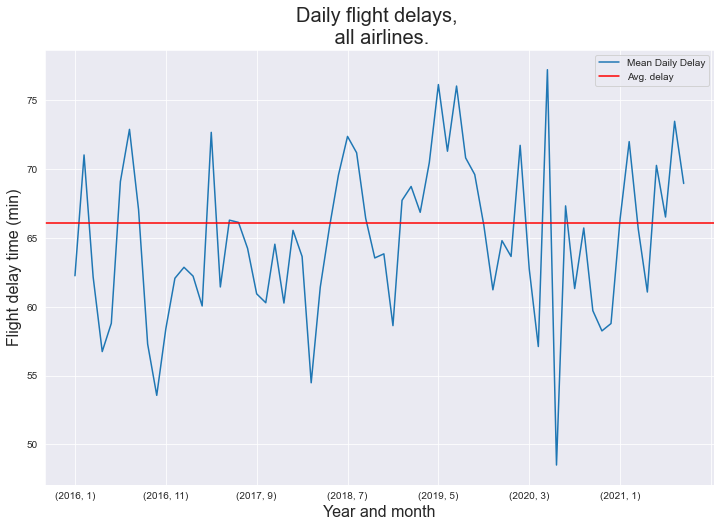

In [33]:
delayed.groupby(by= [delayed.index.year,delayed.index.month])['arr_delay'].mean().plot(kind = 'line', figsize = (12,8), grid = True, label = 'Mean Daily Delay');
#mark a line for the average of all flight delays in the set and highilight peaks above and below. 
sns.set_style('darkgrid')
plt.axhline(y=mean_delay, color='r', linestyle='-', label='Avg. delay')
plt.title('Daily flight delays, \n all airlines.', size = 20);
plt.ylabel('Flight delay time (min)', size = 16);
plt.xlabel('Year and month', size = 16)
plt.legend();
plt.savefig("../Assets/mean_daily_delay_line.pdf", bbox_inches="tight")

### EDA: Year
---
Beginning with the most macro level view of my categorical data, by `year`. 
The boxplot removes outliers. There were a lot of outliers. The reason for keeping outlier data in the dataset is because I intend on using a random forest model with won't require centering or regularization. 

     arr_delay                         
          size   min     max       mean
year                                   
2016     13164  16.0  1660.0  63.455713
2017     14665  16.0  1718.0  63.778452
2018     20025  16.0  1585.0  65.301174
2019     20910  16.0  1609.0  69.532233
2020      6514  16.0  1868.0  63.859226
2021      9658  16.0  1458.0  68.900393


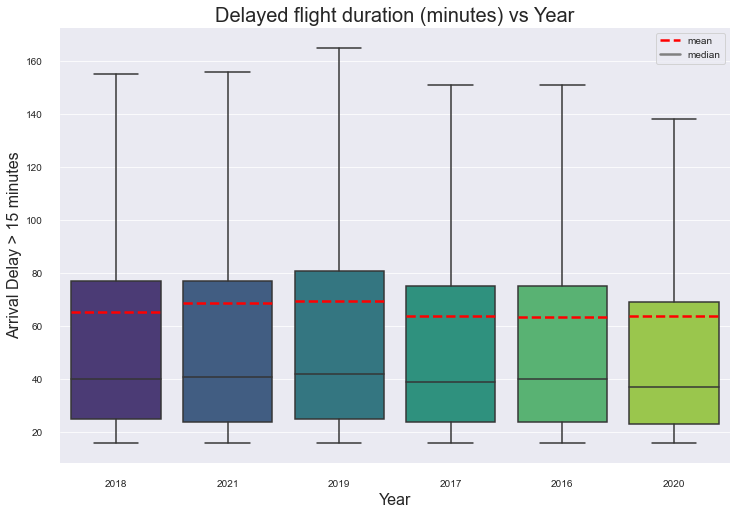

In [34]:
group1= delayed.groupby(['year']).agg({'arr_delay' : ['size', 'min', 'max', 'mean'] })
print(group1)

meanlineprops = dict(linestyle='--', linewidth=2.5, color='red')
sns.set_style('darkgrid')
plt.figure(figsize=(12,8));
plt.title('Delayed flight duration (minutes) vs Year', size = 20)
year = sns.boxplot(x="year", y="arr_delay",
            data=delayed, showfliers = False,
            showmeans = True, meanline= True,
            meanprops = meanlineprops, palette ='viridis')

sns.despine(offset=10, trim=True)
plt.plot([], [], '--', linewidth=2.5, color='red', label='mean')
plt.plot([], [], '-', linewidth=2.5, color='gray', label='median')
plt.xlabel('Year', size = 16)
plt.ylabel('Arrival Delay > 15 minutes', size = 16)

plt.legend()
plt.savefig("../Assets/delays_year_box.pdf", bbox_inches="tight")

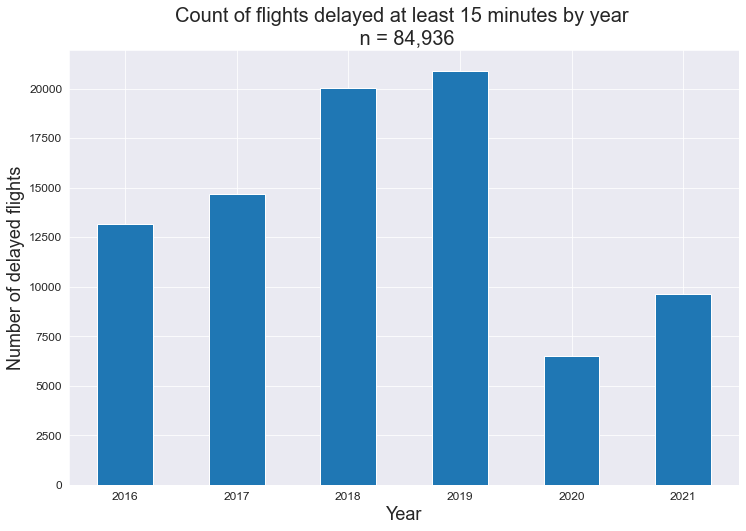

In [35]:
delayed['year'].value_counts().sort_index().plot(kind = 'bar', figsize = (12,8));
sns.set_style('darkgrid')
plt.title(f'Count of flights delayed at least 15 minutes by year \n n = {delayed["year"].count() :,}', size = 20);
plt.xlabel('Year', size = 18 )
plt.xticks(fontsize = 12, rotation = 0)
plt.ylabel('Number of delayed flights', size = 18 )
plt.yticks(fontsize = 12);
plt.savefig("../Assets/delays_year_bar_15_min.pdf", bbox_inches="tight")

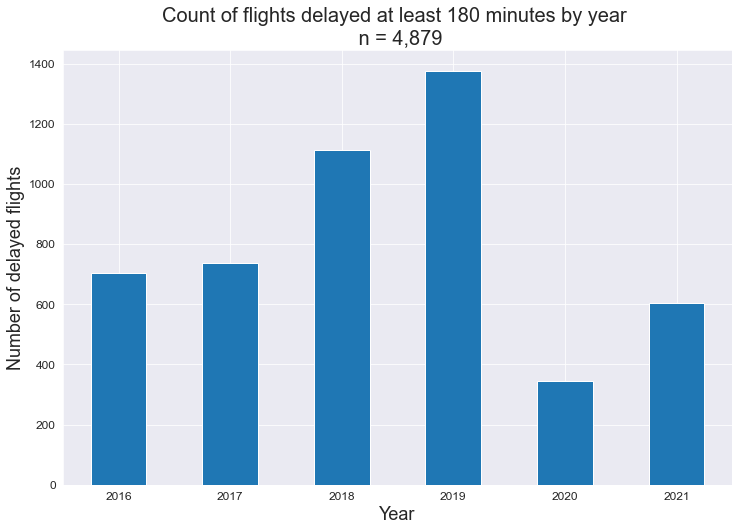

In [36]:
delayed[delayed['arr_delay']>=180]['year'].value_counts().sort_index().plot(kind = 'bar', figsize = (12,8));
sns.set_style('darkgrid')
plt.title(f'Count of flights delayed at least 180 minutes by year \n n = {delayed[delayed["arr_delay"]>=180]["year"].count() :,}', size = 20);
plt.xlabel('Year', size = 18 )
plt.xticks(fontsize = 12, rotation = 0)
plt.ylabel('Number of delayed flights', size = 18 )
plt.yticks(fontsize = 12);
plt.savefig("../Assets/delays_year_bar_180_min.pdf", bbox_inches="tight")

### EDA: Month
---

In [37]:
round(flights['month'].value_counts(normalize = True), 3)

Jul    0.102
Aug    0.100
Jun    0.096
Mar    0.091
Jan    0.086
May    0.085
Feb    0.082
Apr    0.080
Dec    0.075
Oct    0.071
Nov    0.067
Sep    0.066
Name: month, dtype: float64

      arr_delay                         
           size   min     max       mean
month                                   
Apr        6216  16.0  1244.0  65.334781
Aug        9469  16.0  1571.0  68.542085
Dec        6864  16.0  1185.0  61.435023
Feb        7051  16.0  1660.0  67.985108
Jan        7171  16.0  1609.0  64.831683
Jul        9728  16.0  1382.0  72.217928
Jun        9505  16.0  1456.0  68.203577
Mar        6814  16.0  1525.0  61.725271
May        7283  16.0  1718.0  67.486887
Nov        4831  16.0  1585.0  61.893604
Oct        5323  16.0  1473.0  61.791471
Sep        4681  16.0  1868.0  64.450117


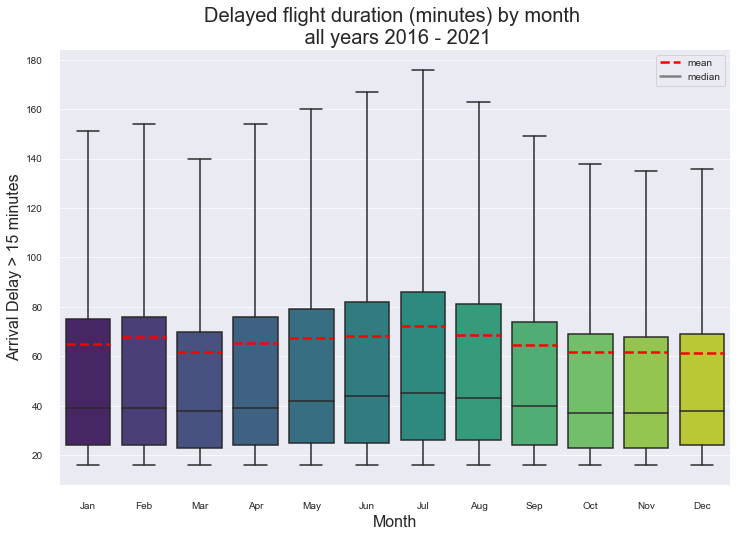

In [38]:
group2= delayed.groupby(['month']).agg({'arr_delay' : ['size', 'min', 'max', 'mean'] })
print(group2)
sns.set_style('darkgrid')
plt.figure(figsize=(12,8));
plt.meanlineprops = dict(linestyle='--', linewidth=2.5, color='purple')
plt.title('Delayed flight duration (minutes) by month \n all years 2016 - 2021', size = 20)
year = sns.boxplot(x="month", y="arr_delay",
            data=delayed, showfliers = False,
            showmeans = True, meanline= True, palette ='viridis',
            meanprops = meanlineprops, order = ['Jan', 'Feb', 'Mar', 'Apr', 'May',
                                                'Jun', 'Jul', 'Aug','Sep', 'Oct', 'Nov', 'Dec'])

sns.despine(offset=10, trim=True)
plt.plot([], [], '--', linewidth=2.5, color='red', label='mean')
plt.plot([], [], '-', linewidth=2.5, color='gray', label='median')
plt.xlabel('Month', size = 16)
plt.ylabel('Arrival Delay > 15 minutes', size = 16)

plt.legend()
plt.savefig("../Assets/delays_month_box.pdf", bbox_inches="tight")

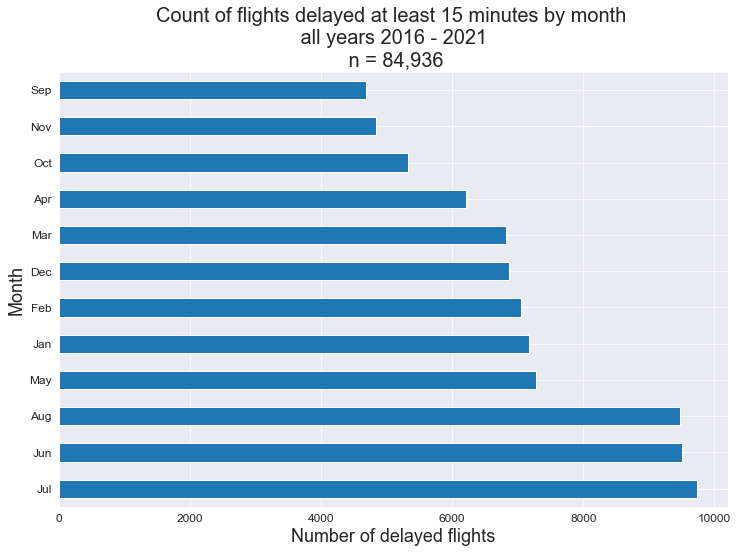

In [39]:
#counts of any delayed flight
round(delayed['month'].value_counts()).plot(kind = 'barh', figsize=(12,8))
sns.set_style('darkgrid')
plt.title(f'Count of flights delayed at least 15 minutes by month \n all years 2016 - 2021 \n n = {delayed[delayed["arr_delay"]>=15]["month"].count() :,}', size = 20);
plt.xlabel('Number of delayed flights', size = 18 )
plt.xticks(fontsize = 12, rotation = 0)
plt.ylabel('Month', size = 18 )
plt.yticks(fontsize = 12);
plt.savefig("../Assets/delays_month_bar_15_min.pdf", bbox_inches="tight")

#### Discussion: Summer months.
----
Traditionally, the summer travel season is the busiest season for airlines to operate flights. 
This means, for business and leisure customer segments there is a higher persistent historical chance of delay due to the increase in flights that are in the air system. 

### EDA: Day of the week. 
---
Next, I will want to take basic counts and measure delays as we did earlier with `year` and `month`. 
<br> 
Like the `month` variable, the data came over encoded with integers as mentioned above. 

            arr_delay                         
                 size   min     max       mean
day_of_week                                   
Fri             13962  16.0  1609.0  64.561381
Mon             13158  16.0  1244.0  69.110883
Sat              9517  16.0  1525.0  65.721551
Sun             11853  16.0  1660.0  67.721421
Thu             13789  16.0  1456.0  65.849880
Tue             11191  16.0  1868.0  65.858815
Wed             11466  16.0  1225.0  63.637275


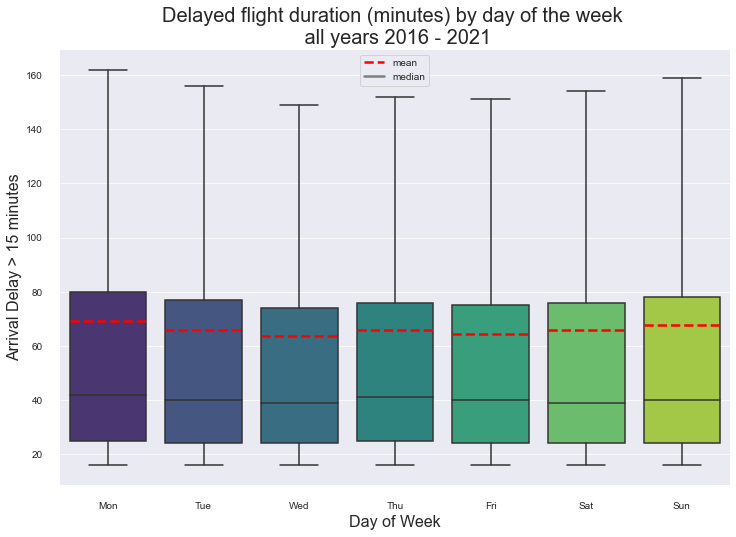

In [40]:
group3= delayed.groupby(['day_of_week']).agg({'arr_delay' : ['size', 'min', 'max', 'mean'] })
print(group3)
sns.set_style('darkgrid')
plt.figure(figsize=(12,8));
plt.meanlineprops = dict(linestyle='--', linewidth=2.5, color='red')
plt.title('Delayed flight duration (minutes) by day of the week \n all years 2016 - 2021' , size = 20)
year = sns.boxplot(x="day_of_week", y="arr_delay",
            data=delayed, showfliers = False,
            showmeans = True, meanline= True, palette = 'viridis',
            meanprops = meanlineprops, order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri',
                                                'Sat', 'Sun'])

sns.despine(offset=10, trim=True)
plt.plot([], [], '--', linewidth=2.5, color='red', label='mean')
plt.plot([], [], '-', linewidth=2.5, color='gray', label='median')
plt.xlabel('Day of Week', size = 16)
plt.ylabel('Arrival Delay > 15 minutes', size = 16)

plt.legend()
plt.savefig("../Assets/delays_daily_box.pdf", bbox_inches="tight")

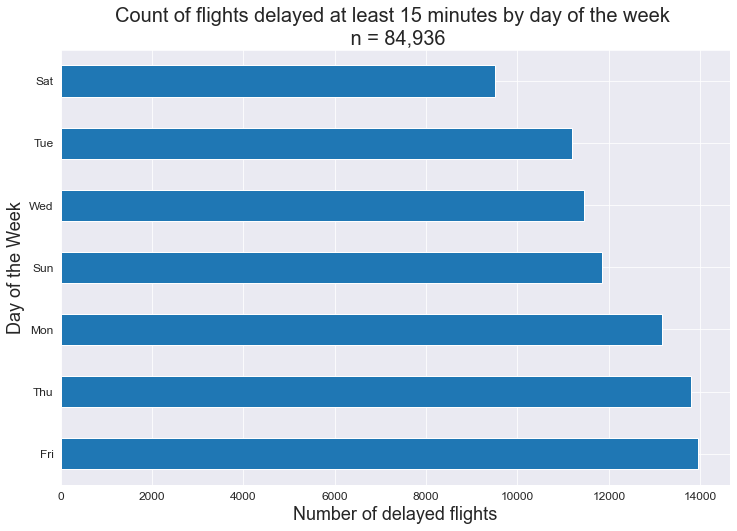

In [41]:
#counts of any delayed flight
round(delayed['day_of_week'].value_counts()).plot(kind = 'barh', figsize=(12,8))
sns.set_style('darkgrid')
plt.title(f'Count of flights delayed at least 15 minutes by day of the week \n n = {delayed.shape[0]:,}', size = 20);
plt.xlabel('Number of delayed flights', size = 18 )
plt.xticks(fontsize = 12, rotation = 0)
plt.ylabel('Day of the Week', size = 18 )
plt.yticks(fontsize = 12);
plt.savefig("../Assets/delays_daily_bar_15_min.pdf", bbox_inches="tight")

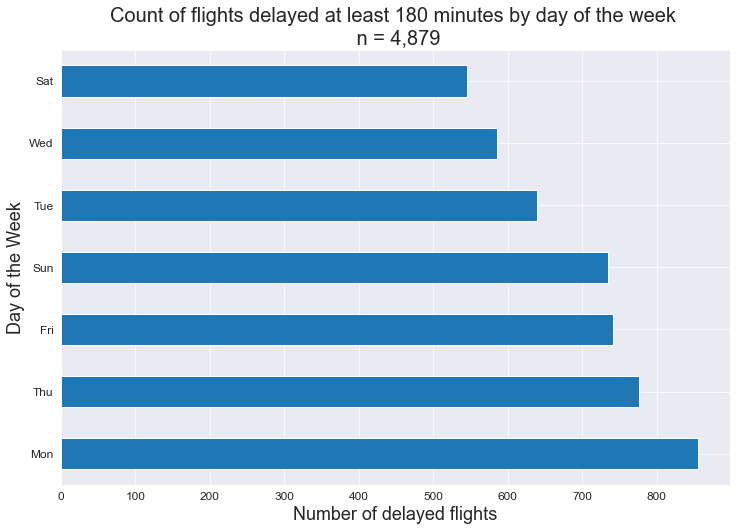

In [42]:
#counts of any delayed flight
round(delayed[delayed['arr_delay']>=180]['day_of_week'].value_counts()).plot(kind = 'barh', figsize=(12,8))
sns.set_style('darkgrid')
plt.title(f'Count of flights delayed at least 180 minutes by day of the week \n n = {delayed[delayed["arr_delay"]>=180].shape[0]:,}', size = 20);
plt.xlabel('Number of delayed flights', size = 18 )
plt.xticks(fontsize = 12, rotation = 0)
plt.ylabel('Day of the Week', size = 18 )
plt.yticks(fontsize = 12);
plt.savefig("../Assets/delays_daily_bar_180_min.pdf", bbox_inches="tight")

In [43]:
flights.head(2)

,year,month,day_of_month,day_of_week,fl_date,airline,tail_num,op_carrier_fl_num,origin,origin_city_name,dest,dest_city_name,crs_dep_time,dep_time,dep_delay,crs_arr_time,arr_time,arr_delay,cancelled,cancellation_code,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2018,Apr,21,Sat,2018-04-21,American Airlines,N199UW,1929,PHL,"Philadelphia, PA",BOS,"Boston, MA",2030,2058.0,28.0,2151,2213.0,22.0,0.0,completed_flight,280.0,22.0,0.0,0.0,0.0,0.0
1,2021,Jul,7,Wed,2021-07-07,Skywest Airlines,N746SK,3179,SAF,"Santa Fe, NM",DFW,"Dallas/Fort Worth, TX",1035,1406.0,211.0,1326,1643.0,197.0,0.0,completed_flight,551.0,0.0,0.0,0.0,0.0,197.0


#### Discussion
There doesn't appear to be a day-to-day difference in the mean delay in the sample data. 
There is an apparent advantage to flying on Saturday, but let's consider the scale of the chart and the actual difference between the highest mean delay on a Saturday vs on a Friday. 

### EDA: Airline and Airports on Arrival Delay (`arr_delay`):
We can review other columns that are specific to company (the airline) and to location (the origin and destination airports) and to the duration of the flight (distance).

#### EDA: Airline Performance
---
Here I present a baseline analysis on the `airline` column and look at delays by airline by length of delay. We will look at cause of delay later in a deeper look to understand what does the proportionality looks like.

In [44]:
delayed['airline'].value_counts()

Southwest Airlines    18066
American Airlines     13082
Skywest Airlines      10117
Delta Airlines         9341
United Airlines        7942
JetBlue                5383
Spirit Airlines        2703
Envoy Air              2677
Alaska Airlines        2656
Republic Airways       2588
PSA Airlines           2434
Frontier Airlines      2145
Mesa Air               1990
Endeavor Air           1879
Allegiant Air          1193
Hawaiian Airlines       597
Horizon Air             143
Name: airline, dtype: int64

In [45]:
delayed['arr_delay'].describe()

count    84936.000000
mean        66.092540
std         83.279757
min         16.000000
25%         24.000000
50%         40.000000
75%         77.000000
max       1868.000000
Name: arr_delay, dtype: float64

In [46]:
#set the order from lowest to highest arrival delay by 3 quartile values
my_order = delayed.groupby(by=["airline"])["arr_delay"].quantile(.75).sort_values(ascending = True).index
my_order

Index(['Hawaiian Airlines', 'Horizon Air', 'Alaska Airlines',
       'Southwest Airlines', 'Envoy Air', 'Delta Airlines',
       'American Airlines', 'Spirit Airlines', 'Frontier Airlines',
       'Allegiant Air', 'Republic Airways', 'PSA Airlines', 'United Airlines',
       'JetBlue', 'Skywest Airlines', 'Endeavor Air', 'Mesa Air'],
      dtype='object', name='airline')

                   arr_delay                         
                        size   min     max       mean
airline                                              
Alaska Airlines         2656  16.0   836.0  50.377259
Allegiant Air           1193  16.0  1312.0  73.694887
American Airlines      13082  16.0  1718.0  66.490445
Delta Airlines          9341  16.0  1130.0  69.719195
Endeavor Air            1879  16.0  1173.0  78.267696
Envoy Air               2677  16.0  1004.0  61.613373
Frontier Airlines       2145  16.0   786.0  67.975758
Hawaiian Airlines        597  16.0   311.0  38.400335
Horizon Air              143  16.0   282.0  47.160839
JetBlue                 5383  16.0  1007.0  74.170537
Mesa Air                1990  16.0  1571.0  80.408543
PSA Airlines            2434  16.0   983.0  67.828266
Republic Airways        2588  16.0   951.0  68.075734
Skywest Airlines       10117  16.0  1868.0  79.878818
Southwest Airlines     18066  16.0   630.0  51.429149
Spirit Airlines         2703

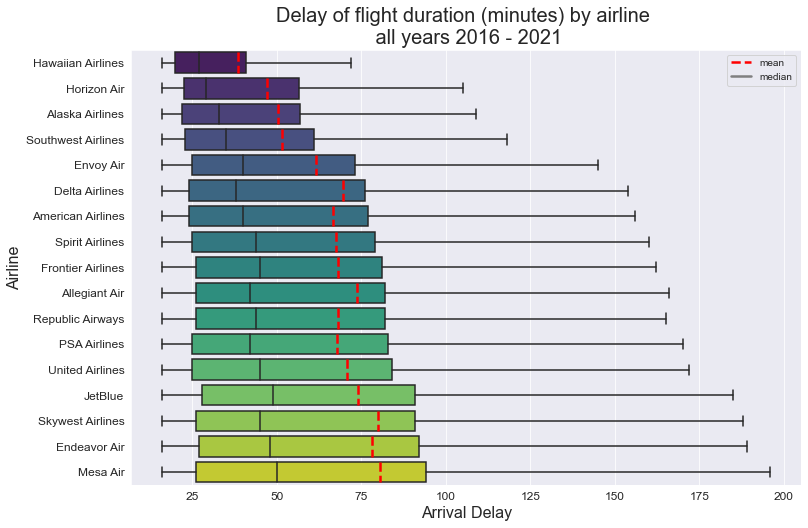

In [47]:
group4= delayed.groupby(['airline']).agg({'arr_delay' : ['size', 'min', 'max', 'mean'] })
print(group4)
sns.set_style('darkgrid')
plt.figure(figsize=(12,8));
plt.meanlineprops = dict(linestyle='--', linewidth=2.5, color='red')
plt.title('Delay of flight duration (minutes) by airline \n all years 2016 - 2021' , size = 20)
year = sns.boxplot(y="airline", x="arr_delay",
            data=delayed, showfliers = False,
            showmeans = True, meanline= True,
                   palette = 'viridis', order = my_order,
                   
            meanprops = meanlineprops)

#sns.despine(offset=10, trim=True)
plt.plot([], [], '--', linewidth=2.5, color='red', label='mean')
plt.plot([], [], '-', linewidth=2.5, color='gray', label='median')
plt.yticks(fontsize = 12)
plt.ylabel('Airline', size = 16)
plt.xticks(fontsize = 12)
plt.xlabel('Arrival Delay', size = 16)

plt.legend()
plt.savefig("../Assets/delays_airline_15_min.pdf", bbox_inches="tight")

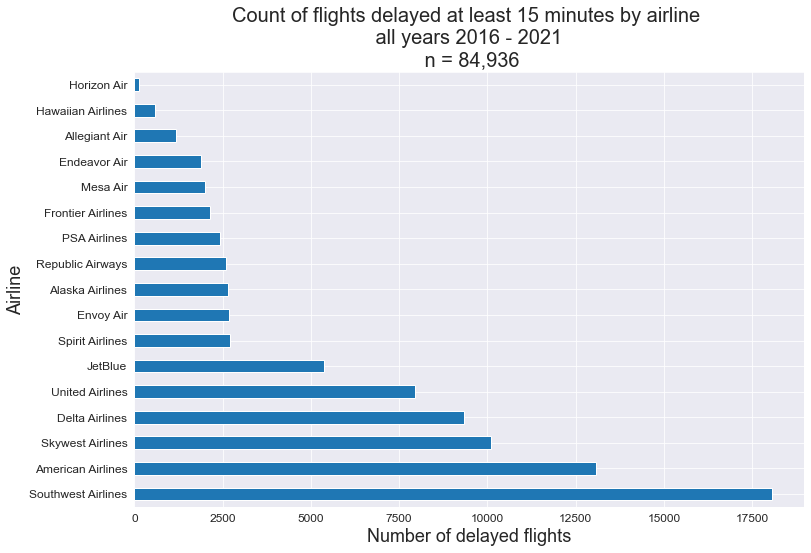

In [48]:
#counts of any delayed flight
round(delayed['airline'].value_counts()).plot(kind = 'barh', figsize=(12,8))
sns.set_style('darkgrid')
plt.title(f'Count of flights delayed at least 15 minutes by airline \n all years 2016 - 2021 \n n = {delayed[delayed["arr_delay"]>=15]["airline"].count() :,}', size = 20);
plt.xlabel('Number of delayed flights', size = 18 )
plt.xticks(fontsize = 12, rotation = 0)
plt.ylabel('Airline', size = 18 )
plt.yticks(fontsize = 12);
plt.savefig("../Assets/delays_airline_bar_15_min.pdf", bbox_inches="tight")

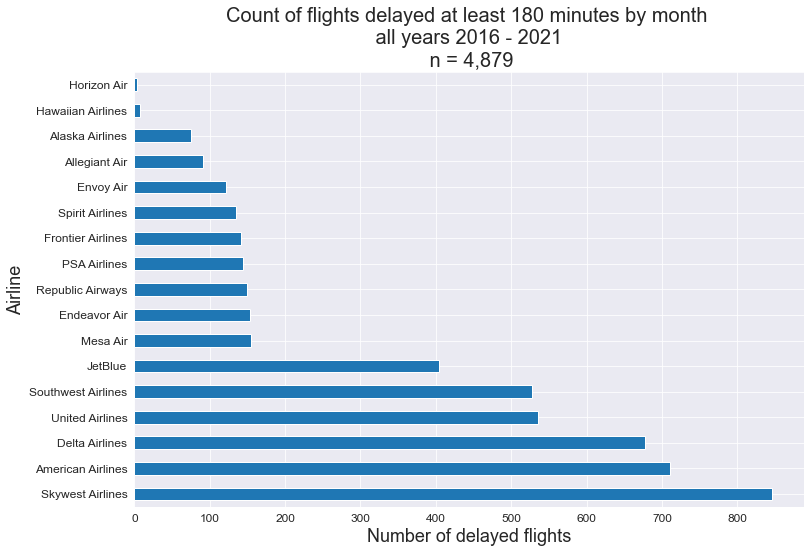

In [49]:
#counts of any delayed flight
round(delayed[delayed['arr_delay']>=180]['airline'].value_counts()).plot(kind = 'barh', figsize=(12,8))
sns.set_style('darkgrid')
plt.title(f'Count of flights delayed at least 180 minutes by month \n all years 2016 - 2021 \n n = {delayed[delayed["arr_delay"]>=180]["airline"].count() :,}', size = 20);
plt.xlabel('Number of delayed flights', size = 18 )
plt.xticks(fontsize = 12, rotation = 0)
plt.ylabel('Airline', size = 18 )
plt.yticks(fontsize = 12);
plt.savefig("../Assets/delays_airline_bar_180_min.pdf", bbox_inches="tight")

#### EDA: Airport Performance
---
A light view on the airports where delayed flights occurred most. 
How many airports exist in the transportation network?
Often we would think of this in terms of a network to analyze performance across the whole system. However, here we just want to know the number of unique nodes involved in airline delays.

In [50]:
#how many airports are there ?
delayed['origin'].nunique()

369

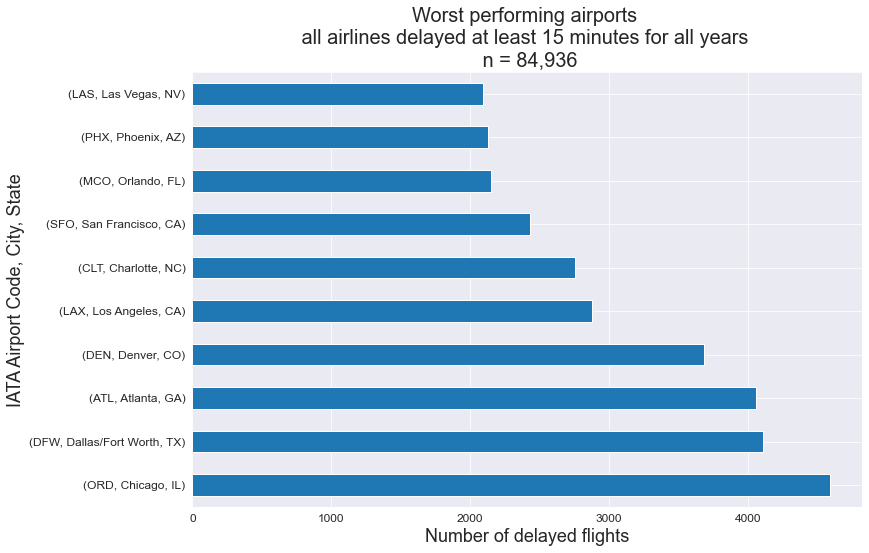

In [51]:
#bottom 10 airports (frequency) for delays, most delayed
sns.set_style('darkgrid')
delayed[['origin', 'origin_city_name']].value_counts().head(10).sort_values(ascending = False).plot(kind = 'barh', figsize = (12,8));
plt.title(f'Worst performing airports \n all airlines delayed at least 15 minutes for all years  \n n = {delayed["arr_delay"].shape[0]:,}', size = 20);
plt.xlabel('Number of delayed flights', size = 18 )
plt.xticks(fontsize = 12, rotation = 0)
plt.ylabel('IATA Airport Code, City, State', size = 18 )
plt.yticks(fontsize = 12);
plt.savefig("../Assets/delays_airport_worst_min.pdf", bbox_inches="tight")

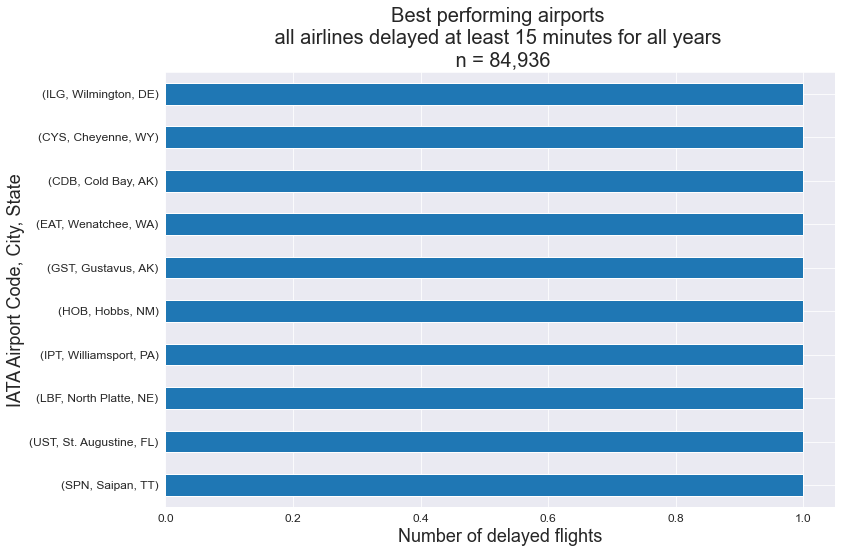

In [52]:
#top 10 airports (frequency) for delays, least delays
sns.set_style('darkgrid')
delayed[['origin', 'origin_city_name']].value_counts().tail(10).sort_values().plot(kind = 'barh', figsize= (12,8))
plt.title(f'Best performing airports \n all airlines delayed at least 15 minutes for all years  \n n = {delayed["arr_delay"].shape[0]:,}', size = 20);
plt.xlabel('Number of delayed flights', size = 18 )
plt.xticks(fontsize = 12, rotation = 0)
plt.ylabel('IATA Airport Code, City, State', size = 18 )
plt.yticks(fontsize = 12);
plt.savefig("../Assets/delays_airport_Best_min.pdf", bbox_inches="tight")

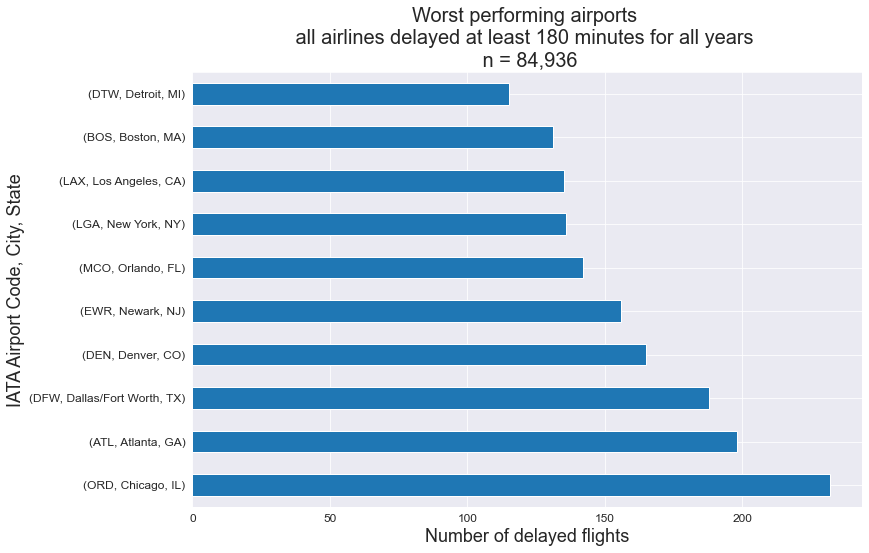

In [53]:
delayed[delayed['arr_delay'] >= 180][['origin', 'origin_city_name']].value_counts().head(10).sort_values(ascending = False).plot(kind = 'barh', figsize = (12,8));
sns.set_style('darkgrid')
plt.title(f'Worst performing airports \n all airlines delayed at least 180 minutes for all years  \n n = {delayed["arr_delay"].shape[0]:,}', size = 20);
plt.xlabel('Number of delayed flights', size = 18 )
plt.xticks(fontsize = 12, rotation = 0)
plt.ylabel('IATA Airport Code, City, State', size = 18 )
plt.yticks(fontsize = 12);
plt.savefig("../Assets/delays_airport_worst_180min.pdf", bbox_inches="tight")

## 4. Feature Engineering

### Feature Engineering: Delay Classes. 
----
It looks as though there were around the same average amount of delay, despite outliers.
Would this average change if we were to define delay _buckets_ ? 

* 0-15 minutes is a negligible delay. We can think of this class as being the not delayed class. This matters less because ticket booking engines contain information that describes an airport's _minimum connection time_ or time the airport has declared one would need, at a minimum, to traverse the concourse(s) to arrive at some other part of the airport. This is set up so passengers are set up for a successful connection. Thus, a ticket agent cannot book a ticket for a passenger with fewer minutes between scheduled arrival time and the next scheduled departure time. Encoded as `cl_delayed` where 1 if the flight arrived outside of its 15-minute arrival window, 0 if the flight arrived early or was within the arrival window  

* 15 - 60 minutes, minor delays, may impact tight connections. Encoded as `cl_sm_delay`

* 61 - 120 minutes, moderate delay, very likely to impact connecting flights or end of flight operations (like parking at an available gate) Encoded as `cl_mod_delay`

* 121 - 180 minutes, long delay. Depending on cause and airline, passenger may be able to make free arrangements to get back on track. Encoded as `cl_lg_delay`

* 181 - 240 minutes very long delay. Significant downline impacts. Lost time at destination, missed connections, depending on routing may also mean overnight stay at some connection point. Encoded as `cl_xl_delay`.

* 241+ minutes / Canceled . Extreme delay. This is anything greater than 4 hours in length or the flight itself is canceled outright. 



### Creating the classes.
---
Here are the steps taken to create each class on the `sample_model` dataframe. 

In [54]:
def delays(x):
    #the series of arr_time comes in
    if (x > 15 and x<=60):
        return '1_sm_delay'
    elif (x > 60 and x<=120):
        return '2_mod_delay'
    elif (x > 120 and x<=180):
        return '3_lg_delay'
    elif (x > 180 and x<=240):
        return '4_xl_delay'
    elif (x > 240 or x==-1):
        return '5_cl_xtreme_delay'
    else:
        return 'no delay'

In [55]:
flights['delay_class'] = flights['arr_delay'].apply(delays)

### Class balances
---
What I have done is create sub-classes on the delayed class. This illuminates different categories of delays but also has a big drawback, it creates an unbalanced data set for which we are to model. 

First lets determine what we are dealing with here initially by looking and visualizing various system performance metrics. 

Then we will attempt to balance our classes just prior to modeling. 

In [56]:
flights['delay_class'].value_counts( ascending = False)

no delay             85786
1_sm_delay           56793
2_mod_delay          17469
5_cl_xtreme_delay     6071
3_lg_delay            5844
4_xl_delay            2399
Name: delay_class, dtype: int64

In [57]:
flights['delay_class'].value_counts( normalize = True)

no delay             0.491999
1_sm_delay           0.325719
2_mod_delay          0.100188
5_cl_xtreme_delay    0.034818
3_lg_delay           0.033516
4_xl_delay           0.013759
Name: delay_class, dtype: float64

Our sample data set contains 1,395,432 flights that were on-time and 1,442,124 that were delayed by any amount of time of 1 minute or greater. 
of the two-and-a-half million delayed flights in the sample: our breakdown is like this, 

|**Delay Class**|**Class Name**|**Count**|**Proportion of <br> delayed flights**|
|---|---|---|---|
|_15 - 60 min_| _Small Delay_| 889,171| 31.34%|
|_61 - 120 min_| _Moderate Delay_ | 272,559|9.61%|
|_121 - 180 min_| _Large Delay_ |93,794|3.31%|
|_181 - 240 min_| _Outsized (XL) Delay_|37,990|1.34%|
|_240+ min_| _Extreme Delay or Canceled_|98,498| 3.47%|

Now I will encode new columns as dummy variables in the usual way. 

In [58]:
flights.columns

Index(['year', 'month', 'day_of_month', 'day_of_week', 'fl_date', 'airline',
       'tail_num', 'op_carrier_fl_num', 'origin', 'origin_city_name', 'dest',
       'dest_city_name', 'crs_dep_time', 'dep_time', 'dep_delay',
       'crs_arr_time', 'arr_time', 'arr_delay', 'cancelled',
       'cancellation_code', 'distance', 'carrier_delay', 'weather_delay',
       'nas_delay', 'security_delay', 'late_aircraft_delay', 'delay_class'],
      dtype='object')

In [60]:
#save copy of cleaned sample dataframe without dummies transformations.
flights.to_csv('../Data/flights_processed_ex_dummies.csv', index = False)

### Feature Engineering: Markets (origin - destination pairs).
---
A flights delay or schedule deviation can happen anywhere along the flight's path from origin to destination. 

I would like to create a column for later investigation that combines our strings from `origin` and `destination` we might be better to see what happens or if one city pair is 

In commercial passenger airline industry, we typically designate these pairs as a single _market_. 

So, stated slightly differently, we want to build a column that constructs our `markets` to determine which ones may be more susceptible to delays. 

In [61]:
cols = ['origin', 'dest']
flights['markets'] = flights[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

In [62]:
flights.head()

,year,month,day_of_month,day_of_week,fl_date,airline,tail_num,op_carrier_fl_num,origin,origin_city_name,dest,dest_city_name,crs_dep_time,dep_time,dep_delay,crs_arr_time,arr_time,arr_delay,cancelled,cancellation_code,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,delay_class,markets
0,2018,Apr,21,Sat,2018-04-21,American Airlines,N199UW,1929,PHL,"Philadelphia, PA",BOS,"Boston, MA",2030,2058.0,28.0,2151,2213.0,22.0,0.0,completed_flight,280.0,22.0,0.0,0.0,0.0,0.0,1_sm_delay,PHL_BOS
1,2021,Jul,7,Wed,2021-07-07,Skywest Airlines,N746SK,3179,SAF,"Santa Fe, NM",DFW,"Dallas/Fort Worth, TX",1035,1406.0,211.0,1326,1643.0,197.0,0.0,completed_flight,551.0,0.0,0.0,0.0,0.0,197.0,4_xl_delay,SAF_DFW
2,2018,Nov,27,Tue,2018-11-27,Envoy Air,N616AE,3630,MIA,"Miami, FL",CLE,"Cleveland, OH",2130,2136.0,6.0,35,101.0,26.0,0.0,completed_flight,1080.0,0.0,6.0,20.0,0.0,0.0,1_sm_delay,MIA_CLE
3,2019,Dec,29,Sun,2019-12-29,Delta Airlines,N898DN,1467,SEA,"Seattle, WA",JFK,"New York, NY",745,757.0,12.0,1600,1624.0,24.0,0.0,completed_flight,2422.0,12.0,0.0,12.0,0.0,0.0,1_sm_delay,SEA_JFK
4,2021,Jan,22,Fri,2021-01-22,American Airlines,N987AM,2882,DFW,"Dallas/Fort Worth, TX",AUS,"Austin, TX",1850,1941.0,51.0,2001,2039.0,38.0,0.0,completed_flight,190.0,13.0,0.0,0.0,0.0,25.0,1_sm_delay,DFW_AUS


In [229]:
flights['markets'].value_counts()

LAX_SFO    6696
SFO_LAX    6479
ORD_LGA    5913
LGA_ORD    5506
LAX_JFK    4961
           ... 
ORD_BRO       1
ELP_CLT       1
BRO_DEN       1
IAD_BGR       1
MIA_JAN       1
Name: markets, Length: 7504, dtype: int64

In [135]:
#just slicing by distance and selecting the markets column
#counting flighs with more than 250 statute miles between origin and destination and showing what they are. 
flights[flights['distance'] >=250]['markets'].value_counts()

LAX_SFO    6696
SFO_LAX    6479
ORD_LGA    5913
LGA_ORD    5506
LAX_JFK    4961
           ... 
OMA_TPA       1
RNO_EWR       1
MIA_ROC       1
SEA_MSN       1
MIA_JAN       1
Name: markets, Length: 6791, dtype: int64

The key take away here is that not every airport connects to each other airport in the network. 
We have 380 unique airports in our sample data. 
If each airport connected to one another the network, in terms of markets, would be: $$ 380 ^ {380} $$ 

However, if we count the number of pairs, I think we can reduce the complexity of the problem that the algorithm sees. That is, creating a dummy variable for each of the sampled _markets_ (_pairs_) we just introduce 6,802 new columns

I will test this out if the model performance demands more complexity to avoid overfit. 

In [136]:
#flights = pd.get_dummies(flights, columns=['markets'], prefix = 'market')

In [137]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2735655 entries, 0 to 2735654
Data columns (total 33 columns):
 #   Column                         Dtype         
---  ------                         -----         
 0   year                           object        
 1   month                          object        
 2   day_of_month                   object        
 3   day_of_week                    object        
 4   fl_date                        datetime64[ns]
 5   airline                        object        
 6   tail_num                       object        
 7   op_carrier_fl_num              object        
 8   origin                         object        
 9   origin_city_name               object        
 10  dest                           object        
 11  dest_city_name                 object        
 12  crs_dep_time                   object        
 13  dep_time                       object        
 14  dep_delay                      float64       
 15  crs_arr_time   

In [230]:
#save copy of cleaned sample dataframe without dummies transformations.
flights.to_csv('flights_processed_ex_dummies.csv', index = False)

In [138]:
#save copy of cleaned sample dataframe
flights.to_csv('flights_processed_w_dummies.csv', index = False)

### EDA: `origin` airport performance with delay classes
---
Do a quick examination on airport specific performance based on our new clasess we made. 

In [139]:
flights.columns

Index(['year', 'month', 'day_of_month', 'day_of_week', 'fl_date', 'airline',
       'tail_num', 'op_carrier_fl_num', 'origin', 'origin_city_name', 'dest',
       'dest_city_name', 'crs_dep_time', 'dep_time', 'dep_delay',
       'crs_arr_time', 'arr_time', 'arr_delay', 'cancelled',
       'cancellation_code', 'distance', 'carrier_delay', 'weather_delay',
       'nas_delay', 'security_delay', 'late_aircraft_delay',
       'delay_class_1_sm_delay', 'delay_class_2_mod_delay',
       'delay_class_3_lg_delay', 'delay_class_4_xl_delay',
       'delay_class_5_cl_xtreme_delay', 'delay_class_no delay', 'markets'],
      dtype='object')

In [141]:
delay_classes = ['delay_class_1_sm_delay', 
                'delay_class_2_mod_delay',
                'delay_class_3_lg_delay',
                'delay_class_4_xl_delay',
                'delay_class_5_cl_xtreme_delay']

In [142]:
airport = flights.groupby('origin')[delay_classes].sum().reset_index()

In [143]:
airport = airport.set_index('origin', drop =True)

In [144]:
airport['total_delays'] = airport.sum(axis = 1)

In [145]:
airport.columns

Index(['delay_class_1_sm_delay', 'delay_class_2_mod_delay',
       'delay_class_3_lg_delay', 'delay_class_4_xl_delay',
       'delay_class_5_cl_xtreme_delay', 'total_delays'],
      dtype='object')

In [146]:
worst_10 = airport.sort_values(by =['total_delays'], ascending = False).head(10).copy()
worst_10

,delay_class_1_sm_delay,delay_class_2_mod_delay,delay_class_3_lg_delay,delay_class_4_xl_delay,delay_class_5_cl_xtreme_delay,total_delays
origin,,,,,,
ORD,46777.0,16591.0,5512.0,2137.0,5201.0,76218.0
DFW,42995.0,13625.0,4548.0,1646.0,4841.0,67655.0
ATL,45421.0,11976.0,4019.0,1569.0,3822.0,66807.0
DEN,40128.0,11969.0,3725.0,1257.0,3078.0,60157.0
LAX,31454.0,8655.0,2708.0,1004.0,2264.0,46085.0
CLT,29353.0,8628.0,2724.0,906.0,2539.0,44150.0
SFO,24530.0,8648.0,2891.0,1134.0,2274.0,39477.0
LAS,24397.0,6543.0,2106.0,704.0,1691.0,35441.0
PHX,24505.0,6278.0,1855.0,658.0,1547.0,34843.0


In [147]:
worst_10_x = worst_10.drop(columns=['total_delays'])

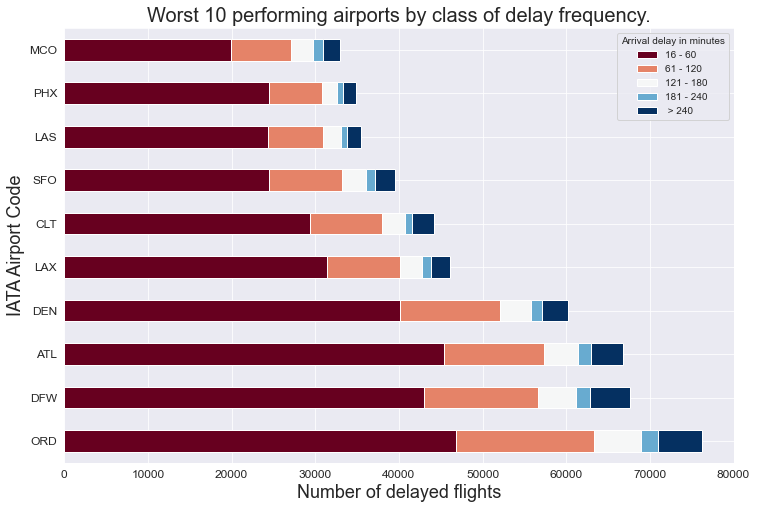

In [148]:
worst_10_x.plot(kind='barh', stacked =True, cmap = 'RdBu', figsize = (12,8));
sns.set_style('darkgrid')
plt.title('Worst 10 performing airports by class of delay frequency.', size = 20);
plt.xlabel('Number of delayed flights', size = 18 )
plt.xticks(fontsize = 12, rotation = 0)
plt.ylabel('IATA Airport Code', size = 18 )
plt.yticks(fontsize = 12);
plt.legend(['16 - 60', '61 - 120', '121 - 180', '181 - 240', ' > 240'],title = 'Arrival delay in minutes')
plt.savefig("../Assets/STACKED_delays_airport_worst_all_delays.pdf", bbox_inches="tight")

### EDA: `airline` performance with delay classes
---
Do a quick examination on airline specific performance based on our new classes we made. 

In [150]:
#arilines
airlines = flights.groupby('airline')[delay_classes].sum().reset_index()

In [151]:
airlines = airlines.set_index('airline', drop =True)

In [152]:
airlines['total_delays'] = airlines.sum(axis = 1)

In [153]:
airlines = airlines.sort_values(by =['total_delays'], ascending = False).copy()
airline_x = airlines.drop(columns = ['total_delays'])

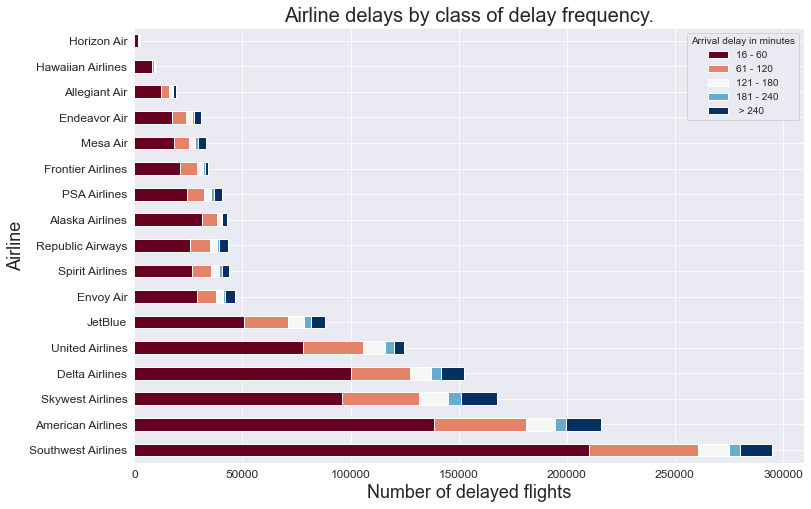

In [154]:
airline_x.plot(kind='barh', stacked =True, cmap = 'RdBu', figsize = (12,8));
sns.set_style('darkgrid')
plt.title('Airline delays by class of delay frequency.', size = 20);
plt.xlabel('Number of delayed flights', size = 18 )
plt.xticks(fontsize = 12, rotation = 0)
plt.ticklabel_format(axis= 'x', useOffset = False, style = 'plain')
plt.ylabel('Airline', size = 18 )
plt.yticks(fontsize = 12);

plt.legend(['16 - 60', '61 - 120', '121 - 180', '181 - 240', ' > 240'],title = 'Arrival delay in minutes')
plt.savefig("../Assets/STACKED_delays_airline_worst_all_delays.pdf", bbox_inches="tight")

In [155]:
airlines_yr = flights.groupby([flights['fl_date'].dt.year, 'airline'])[delay_classes].sum()

In [156]:
airlines_yr['total_delay'] = airlines_yr[delay_classes].sum(axis = 1)

In [157]:
airlines_yr = airlines_yr.sort_values('total_delay', ascending= False).sort_index(level='fl_date', sort_remaining=False)

In [158]:
airlines_yr_x = airlines_yr.drop(columns=['total_delay'])

In [159]:
air_group =airlines_yr_x.groupby(level=0)

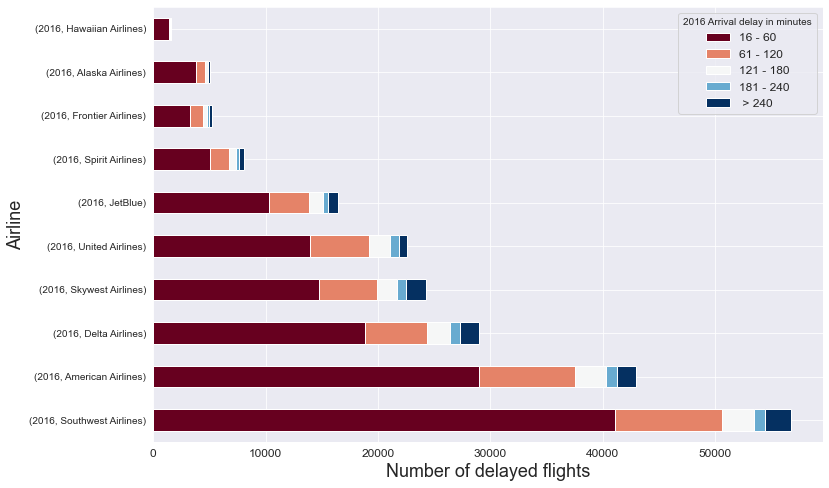

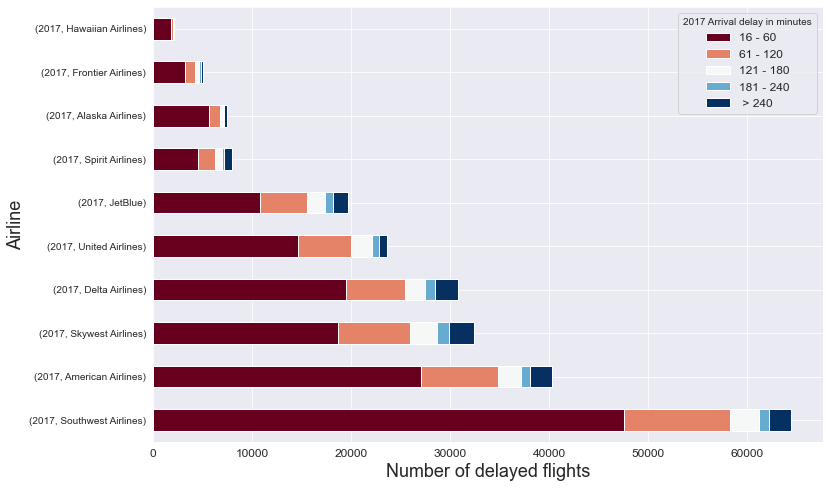

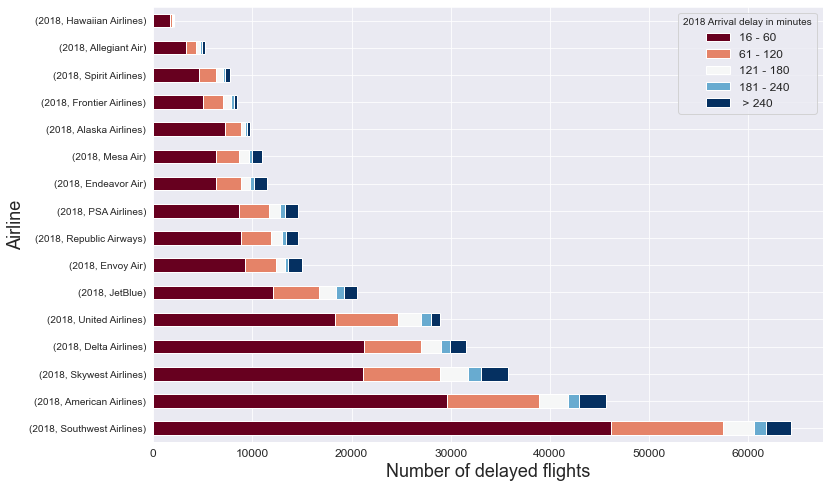

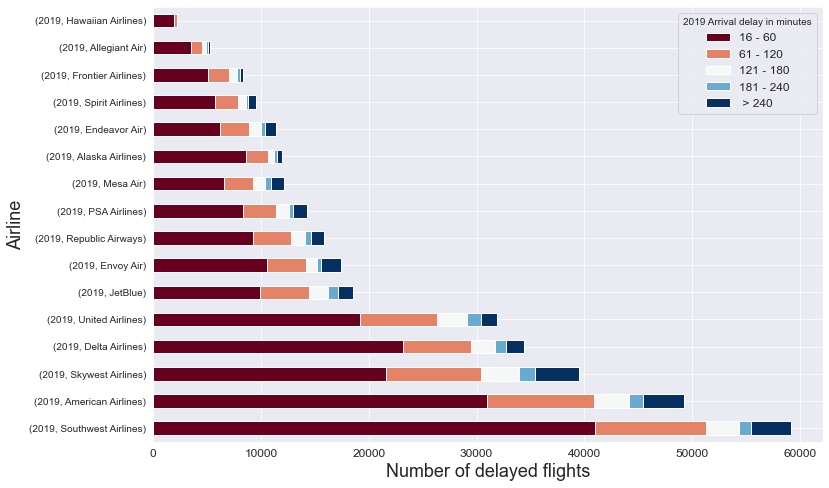

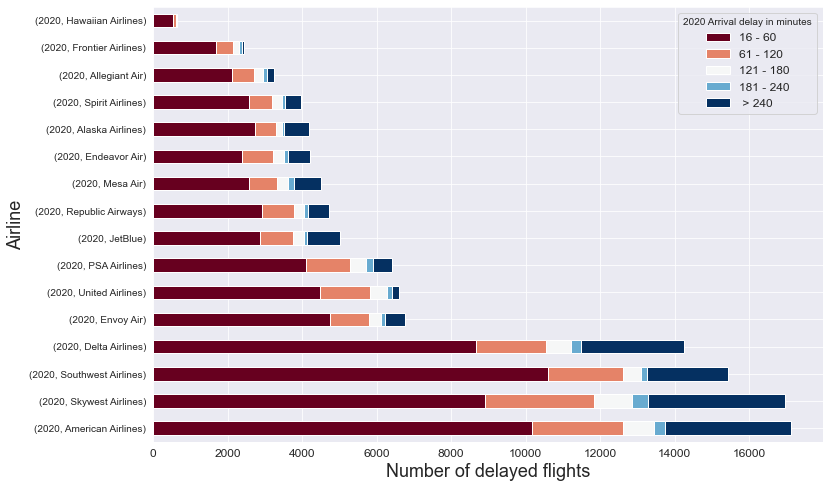

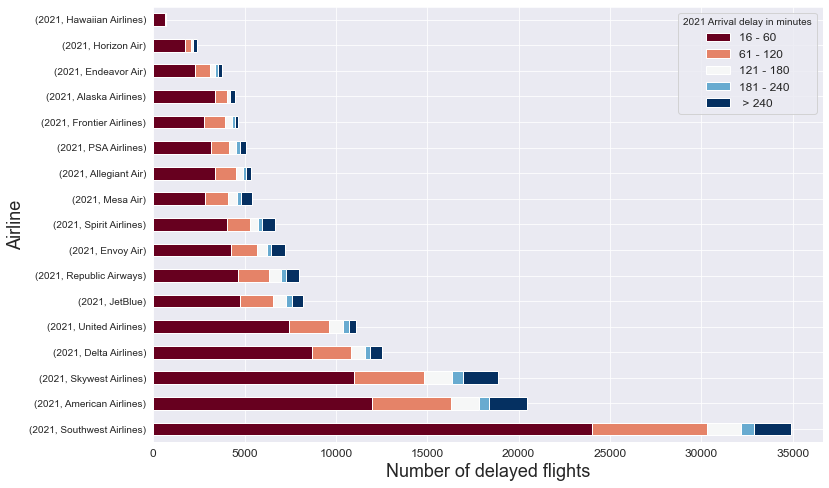

In [160]:
for yr, df_group in air_group:
    sns.set_style('darkgrid')
    df_group.groupby(level =0).plot(kind='barh', stacked =True, cmap = 'RdBu', figsize = (12,8));
    plt.xlabel('Number of delayed flights', size = 18 )
    plt.xticks(fontsize = 12, rotation = 0)
    plt.ticklabel_format(axis= 'x', useOffset = False, style = 'plain')
    plt.ylabel('Airline', size = 18 )
    plt.legend(['16 - 60', '61 - 120', '121 - 180', '181 - 240', ' > 240'],title = f'{yr} Arrival delay in minutes', fontsize = 12)
    plt.savefig(f"../Assets/STACKED_{yr}__airline.pdf", bbox_inches="tight")

In [231]:
flights.isnull().sum()

year                   0
month                  0
day_of_month           0
day_of_week            0
fl_date                0
airline                0
tail_num               0
op_carrier_fl_num      0
origin                 0
origin_city_name       0
dest                   0
dest_city_name         0
crs_dep_time           0
dep_time               0
dep_delay              0
crs_arr_time           0
arr_time               0
arr_delay              0
cancelled              0
cancellation_code      0
distance               0
carrier_delay          0
weather_delay          0
nas_delay              0
security_delay         0
late_aircraft_delay    0
delay_class            0
markets                0
dtype: int64

### EDA: `airline` airport performance with delay types
---
Do a quick examination on airport specific performance based on each delay cause. 

In [162]:
delay_type_airline = flights.groupby([flights['fl_date'].dt.year, 'airline'])[['late_aircraft_delay','carrier_delay', 'weather_delay', 'nas_delay', 'security_delay']].sum()

In [163]:
delay_type_airline['total_delay_minutes'] = delay_type_airline[['carrier_delay', 'weather_delay', 'nas_delay', 'security_delay','late_aircraft_delay']].sum(axis=1)

In [164]:
delay_type_airline = delay_type_airline.sort_values('total_delay_minutes', ascending= False).sort_index(level='fl_date', sort_remaining=False)

In [165]:
#now sorted, remove total delay column. 
delay_type_airline_x = delay_type_airline.drop(columns=['total_delay_minutes'])

In [166]:
#create a group object to iterate over
air_type_group =delay_type_airline_x.groupby(level=0)

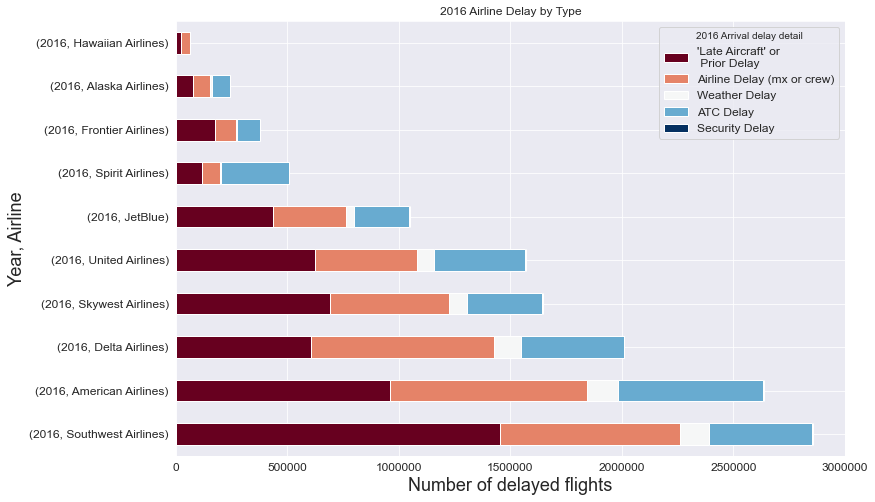

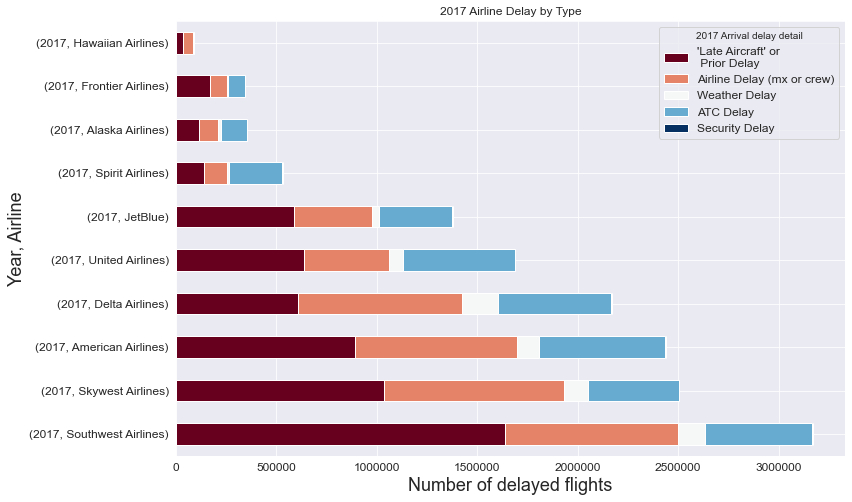

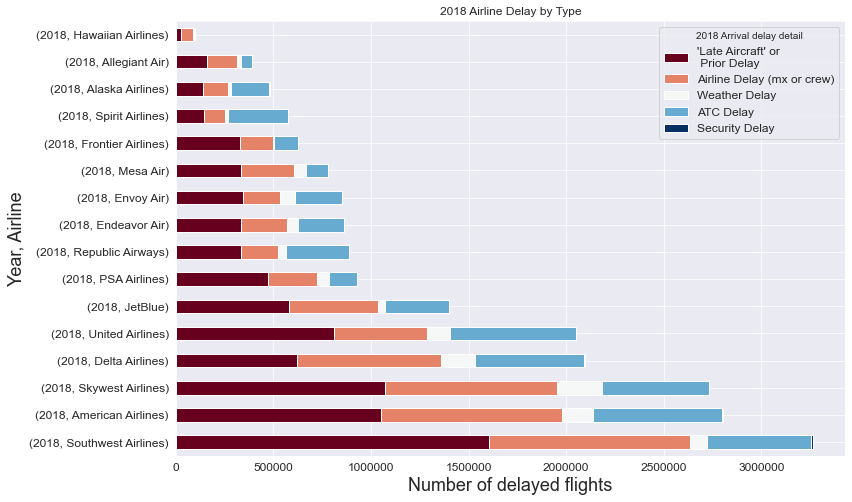

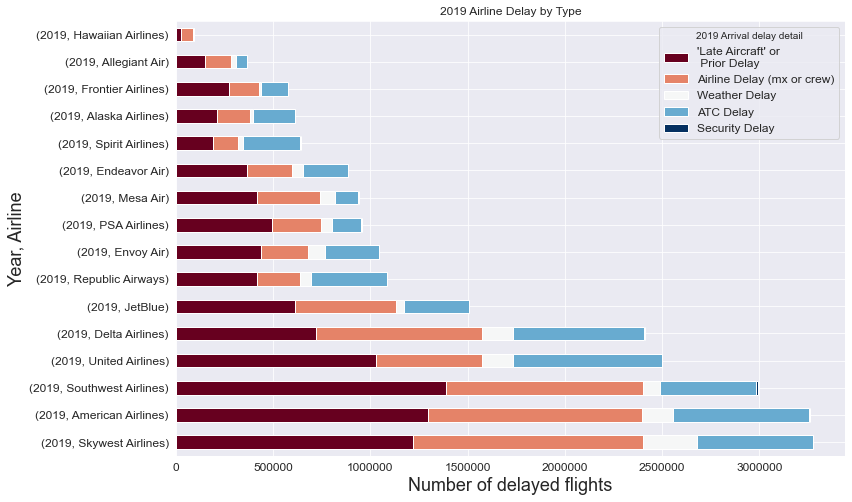

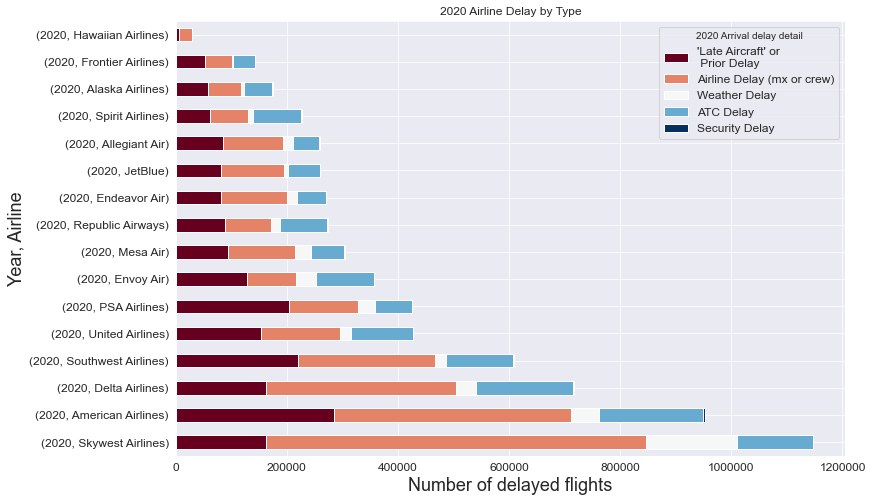

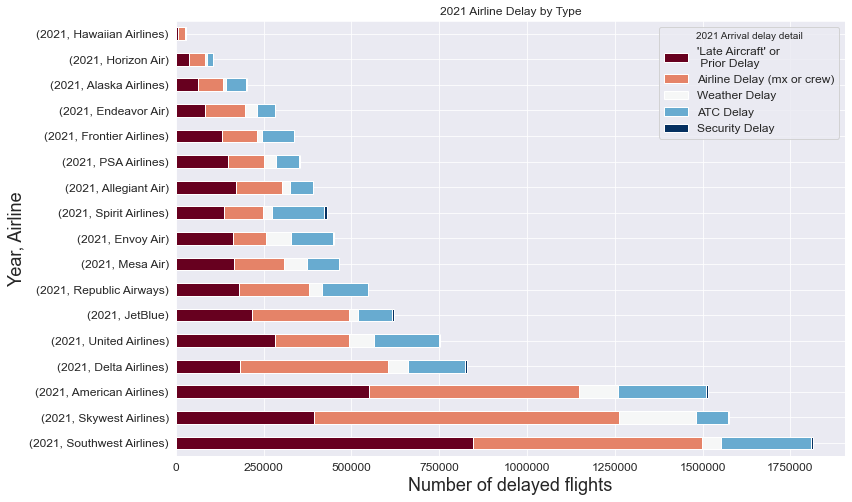

In [167]:
for yr, df_group in air_type_group:
    sns.set_style('darkgrid')
    df_group.groupby(level =0).plot(kind='barh', stacked =True, cmap = 'RdBu', figsize = (12,8), legend=True, title = f'{yr} Airline Delay by Type');
    plt.xlabel('Number of delayed flights', size = 18 )
    plt.xticks(fontsize = 12, rotation = 0)
    plt.ticklabel_format(axis= 'x', useOffset = False, style = 'plain')
    plt.ylabel('Year, Airline', size = 18 )
    plt.yticks(fontsize = 12);
    plt.legend(['\'Late Aircraft\' or\n Prior Delay','Airline Delay (mx or crew)', 'Weather Delay', 'ATC Delay', 'Security Delay'],title = f'{yr} Arrival delay detail', fontsize = 12)
    plt.savefig(f"../Assets/STACKED_detail_{yr}__airline.pdf", bbox_inches="tight")

In [168]:
flights.head(2)

,year,month,day_of_month,day_of_week,fl_date,airline,tail_num,op_carrier_fl_num,origin,origin_city_name,dest,dest_city_name,crs_dep_time,dep_time,dep_delay,crs_arr_time,arr_time,arr_delay,cancelled,cancellation_code,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,delay_class_1_sm_delay,delay_class_2_mod_delay,delay_class_3_lg_delay,delay_class_4_xl_delay,delay_class_5_cl_xtreme_delay,delay_class_no delay,markets
0,2020,Sep,4,Fri,2020-09-04,Southwest Airlines,N8529Z,363,MDW,"Chicago, IL",DTW,"Detroit, MI",1350,1404.0,14.0,1600,1555.0,0.0,0.0,completed_flight,228.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,MDW_DTW
1,2017,Feb,10,Fri,2017-02-10,American Airlines,N3KJAA,2586,ORD,"Chicago, IL",SFO,"San Francisco, CA",1659,1702.0,3.0,1942,2006.0,24.0,0.0,completed_flight,1846.0,0.0,0.0,24.0,0.0,0.0,1,0,0,0,0,0,ORD_SFO


In [169]:
flights.isnull().sum()

year                             0
month                            0
day_of_month                     0
day_of_week                      0
fl_date                          0
airline                          0
tail_num                         0
op_carrier_fl_num                0
origin                           0
origin_city_name                 0
dest                             0
dest_city_name                   0
crs_dep_time                     0
dep_time                         0
dep_delay                        0
crs_arr_time                     0
arr_time                         0
arr_delay                        0
cancelled                        0
cancellation_code                0
distance                         0
carrier_delay                    0
weather_delay                    0
nas_delay                        0
security_delay                   0
late_aircraft_delay              0
delay_class_1_sm_delay           0
delay_class_2_mod_delay          0
delay_class_3_lg_del

#### EDA: `year`, `'origin'` and `airline` airport performance with delay types
---
Do a quick examination on airport specific performance based on each delay cause. 
This is not used in the model but maybe used in the application. 

In [170]:
delay_type_airport = flights.groupby([flights['fl_date'].dt.year, 'origin', 'airline'])[['late_aircraft_delay','carrier_delay', 'weather_delay', 'nas_delay', 'security_delay']].sum()

In [171]:
delay_type_airport['total_delay_minutes'] = delay_type_airport[['carrier_delay', 'weather_delay', 'nas_delay', 'security_delay','late_aircraft_delay']].sum(axis=1)

In [172]:
delay_type_airport = delay_type_airport.sort_values('total_delay_minutes', ascending= False).sort_index(level='fl_date', sort_remaining=False)

In [173]:
delay_type_airport.loc[:, 'SEA', : ].head(30)

late_aircraft_delay  carrier_delay  \
fl_date origin airline                                                  
2016    SEA    Alaska Airlines                 12806.0        29685.0   
               Skywest Airlines                16356.0        15269.0   
               Delta Airlines                  10665.0        17444.0   
               Southwest Airlines              17872.0        10111.0   
               American Airlines                9097.0        13489.0   
               United Airlines                  8258.0         7626.0   
               JetBlue                          4429.0         1890.0   
               Frontier Airlines                1300.0          860.0   
               Spirit Airlines                   627.0          620.0   
               Hawaiian Airlines                   0.0         1149.0   
2017    SEA    Alaska Airlines                 21605.0        37870.0   
               Skywest Airlines                23661.0        17996.0   
               Delta Airlines                  11936.0        15831.0   
               Southwest Airlines              17561.0         7620.0   
               United Airlines                  9020.0         6275.0   
               American Airlines                6074.0         8513.0   
               JetBlue                          5216.0         2987.0   
               Spirit Airlines                  1677.0         1062.0   
               Hawaiian Airlines                   0.0         1742.0   
               Frontier Airlines                1214.0          198.0   
2018    SEA    Alaska Airlines                 28445.0        32997.0   
               Delta Airlines                  15457.0        24889.0   
               United Airlines                 12262.0        10382.0   
               Southwest Airlines              20299.0         7495.0   
               Skywest Airlines                15902.0         6282.0   
               American Airlines                7614.0         6583.0   
               Spirit Airlines                  2703.0         2251.0   
               JetBlue                          3250.0         2780.0   
               Frontier Airlines                2897.0          969.0   
               Hawaiian Airlines                   0.0         2643.0   

                                   weather_delay  nas_delay  security_delay  \
fl_date origin airline                                                        
2016    SEA    Alaska Airlines            1657.0    29851.0            83.0   
               Skywest Airlines           2234.0     5381.0             0.0   
               Delta Airlines              882.0     8249.0             0.0   
               Southwest Airlines          461.0     5109.0            17.0   
               American Airlines          1014.0     4493.0             3.0   
               United Airlines             175.0     7169.0             0.0   
               JetBlue                     126.0     1711.0             0.0   
               Frontier Airlines             0.0     1523.0             0.0   
               Spirit Airlines               0.0     1024.0             0.0   
               Hawaiian Airlines            53.0       12.0             0.0   
2017    SEA    Alaska Airlines            5016.0    46500.0           379.0   
               Skywest Airlines           6402.0     7614.0           162.0   
               Delta Airlines             4552.0    13397.0           217.0   
               Southwest Airlines          814.0     3247.0            11.0   
               United Airlines             649.0     7932.0            54.0   
               American Airlines           952.0     4386.0            11.0   
               JetBlue                     113.0     2377.0             0.0   
               Spirit Airlines               6.0     3634.0            28.0   
               Hawaiian Airlines           230.0       83.0             0.0   
               Frontier Airlines       

In [174]:
flights.columns

Index(['year', 'month', 'day_of_month', 'day_of_week', 'fl_date', 'airline',
       'tail_num', 'op_carrier_fl_num', 'origin', 'origin_city_name', 'dest',
       'dest_city_name', 'crs_dep_time', 'dep_time', 'dep_delay',
       'crs_arr_time', 'arr_time', 'arr_delay', 'cancelled',
       'cancellation_code', 'distance', 'carrier_delay', 'weather_delay',
       'nas_delay', 'security_delay', 'late_aircraft_delay',
       'delay_class_1_sm_delay', 'delay_class_2_mod_delay',
       'delay_class_3_lg_delay', 'delay_class_4_xl_delay',
       'delay_class_5_cl_xtreme_delay', 'delay_class_no delay', 'markets'],
      dtype='object')

### Feature Engineering: dummy variable columns.
---
Now that we have some sense of what the data suggests in terms of flight delays, we can now encode some descriptive columns to see if they have any correlation with having a flight delay. 
I will encode the following columns: `month`, `day_of_month`, `day_of_week`, `airline`


In [175]:
flights = pd.get_dummies(flights, columns=['month'], prefix = 'MM')

In [176]:
flights = pd.get_dummies(flights, columns=['day_of_month'], prefix = 'DD')

In [177]:
flights = pd.get_dummies(flights, columns=['day_of_week'], prefix = 'wk')

In [178]:
flights = pd.get_dummies(flights, columns=['airline'], prefix = 'op') #operator of airline

In [232]:
flights.isnull().sum().sum()

0

## EDA: Correlation investigation
---
Correlations are presented after feature engineering primarily because I have some domain knowledge in the industry. Correlations here are problematic across many columns due to _data leakage_. Nevertheless, correlation tables are reported below on the full sample and then on the `delayed` subset.

In [181]:
cols = flights.describe().columns.to_list()
cols

['dep_delay',
 'arr_delay',
 'cancelled',
 'distance',
 'carrier_delay',
 'weather_delay',
 'nas_delay',
 'security_delay',
 'late_aircraft_delay',
 'delay_class_1_sm_delay',
 'delay_class_2_mod_delay',
 'delay_class_3_lg_delay',
 'delay_class_4_xl_delay',
 'delay_class_5_cl_xtreme_delay',
 'delay_class_no delay',
 'MM_Apr',
 'MM_Aug',
 'MM_Dec',
 'MM_Feb',
 'MM_Jan',
 'MM_Jul',
 'MM_Jun',
 'MM_Mar',
 'MM_May',
 'MM_Nov',
 'MM_Oct',
 'MM_Sep',
 'DD_1',
 'DD_10',
 'DD_11',
 'DD_12',
 'DD_13',
 'DD_14',
 'DD_15',
 'DD_16',
 'DD_17',
 'DD_18',
 'DD_19',
 'DD_2',
 'DD_20',
 'DD_21',
 'DD_22',
 'DD_23',
 'DD_24',
 'DD_25',
 'DD_26',
 'DD_27',
 'DD_28',
 'DD_29',
 'DD_3',
 'DD_30',
 'DD_31',
 'DD_4',
 'DD_5',
 'DD_6',
 'DD_7',
 'DD_8',
 'DD_9',
 'wk_Fri',
 'wk_Mon',
 'wk_Sat',
 'wk_Sun',
 'wk_Thu',
 'wk_Tue',
 'wk_Wed',
 'op_Alaska Airlines',
 'op_Allegiant Air',
 'op_American Airlines',
 'op_Delta Airlines',
 'op_Endeavor Air',
 'op_Envoy Air',
 'op_Frontier Airlines',
 'op_Hawaiian Airline

In [182]:
#all flights 
flights[cols].corr()

,dep_delay,arr_delay,cancelled,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,delay_class_1_sm_delay,delay_class_2_mod_delay,delay_class_3_lg_delay,delay_class_4_xl_delay,delay_class_5_cl_xtreme_delay,delay_class_no delay,MM_Apr,MM_Aug,MM_Dec,MM_Feb,MM_Jan,MM_Jul,MM_Jun,MM_Mar,MM_May,MM_Nov,MM_Oct,MM_Sep,DD_1,DD_10,DD_11,DD_12,DD_13,DD_14,DD_15,DD_16,DD_17,DD_18,DD_19,DD_2,DD_20,DD_21,DD_22,DD_23,DD_24,DD_25,DD_26,DD_27,DD_28,DD_29,DD_3,DD_30,DD_31,DD_4,DD_5,DD_6,DD_7,DD_8,DD_9,wk_Fri,wk_Mon,wk_Sat,wk_Sun,wk_Thu,wk_Tue,wk_Wed,op_Alaska Airlines,op_Allegiant Air,op_American Airlines,op_Delta Airlines,op_Endeavor Air,op_Envoy Air,op_Frontier Airlines,op_Hawaiian Airlines,op_Horizon Air,op_JetBlue,op_Mesa Air,op_PSA Airlines,op_Republic Airways,op_Skywest Airlines,op_Southwest Airlines,op_Spirit Airlines,op_United Airlines
dep_delay,1.000000,0.978149,-0.067663,0.006346,0.680981,0.302058,0.250760,0.032619,0.581976,-0.035089,0.238482,0.305627,0.297017,0.384785,-0.432386,-0.008947,0.022919,0.003641,-0.002287,-0.006942,0.039298,0.031955,-0.023701,0.001521,-0.025880,-0.021691,-0.023931,0.002493,-0.001377,0.003731,-0.000710,0.000231,0.000899,0.004339,-0.001661,0.004265,0.005780,0.004386,0.002802,0.004808,0.004112,-0.000936,-0.004400,-0.002476,-0.005286,-0.002859,-0.004563,-0.001983,-0.005635,-0.000946,-0.000181,-0.000929,-0.007458,-0.005117,-0.000952,0.002615,0.003689,0.001940,0.010229,0.011741,-0.009116,0.002371,0.008404,-0.011580,-0.013735,-0.029291,0.014711,0.003161,-0.025005,-0.001299,-0.009401,0.019761,-0.024905,-0.009058,0.038322,0.018747,0.007286,-0.008110,0.030638,-0.035520,0.007985,0.016941
arr_delay,0.978149,1.000000,-0.071479,0.007116,0.671799,0.310281,0.347101,0.031583,0.564255,-0.010220,0.254943,0.314303,0.302244,0.385542,-0.470201,-0.010244,0.024066,0.004753,0.000249,-0.006793,0.039511,0.033378,-0.026309,0.001011,-0.027059,-0.022261,-0.024657,0.002530,-0.000909,0.004295,-0.000557,0.001263,0.000650,0.005433,-0.002205,0.005383,0.005660,0.004591,0.003551,0.005210,0.004215,-0.001959,-0.004760,-0.003092,-0.006496,-0.002543,-0.005535,-0.001616,-0.006580,-0.001351,-0.000205,-0.001266,-0.008360,-0.005624,0.000108,0.003651,0.003051,0.001853,0.010887,0.011571,-0.012171,0.000942,0.010726,-0.011500,-0.012417,-0.024615,0.016809,0.009304,-0.028154,-0.001324,-0.002234,0.019413,-0.023973,-0.009523,0.038666,0.020153,0.006906,-0.003216,0.033107,-0.049626,0.008694,0.017961
cancelled,-0.067663,-0.071479,1.000000,-0.035052,-0.033189,-0.012662,-0.043090,-0.003613,-0.047853,-0.100736,-0.048263,-0.027328,-0.017151,0.758876,-0.142805,0.030409,-0.001481,-0.015383,0.011798,0.008679,-0.010102,-0.011524,0.050855,-0.014639,-0.023721,-0.022115,-0.007991,-0.001052,-0.004242,0.002964,-0.004730,-0.000581,0.004162,0.002554,-0.003326,0.007581,0.000883,-0.000181,0.003746,0.000834,0.000929,-0.001328,0.000580,0.000090,-0.000878,-0.000732,0.001432,-0.003885,-0.002609,-0.000914,-0.000110,0.005165,-0.001501,-0.005601,-0.000022,0.003315,-0.000919,-0.000780,-0.003060,0.002930,-0.005351,-0.002229,-0.001257,0.003824,0.004917,-0.002086,-0.012845,0.013192,-0.022013,0.005022,0.027224,-0.020463,-0.013798,0.004108,0.007561,0.017496,0.009503,0.012948,0.016726,0.001830,0.009992,-0.044715
distance,0.006346,0.007116,-0.035052,1.000000,0.015030,-0.012075,0.032397,0.005920,-0.020683,0.036961,0.001561,-0.001340,-0.000593,-0.026961,-0.024992,-0.001243,0.004421,0.006039,-0.005778,-0.004905,0.010031,0.004678,0.002978,-0.002068,-0.004296,-0.006117,-0.006947,0.000698,-0.001017,-0.001925,-0.002636,-0.001557,0.000121,-0.000099,0.001207,0.001049,-0.001005,-0.000063,0.000906,0.000734,0.000493,-0.000337,-0.000664,-0.000371,0.000818,0.000360,-0.000690,0.000096,0.001464,0.000663,0.000917,0.000966,0.001186,0.000988,-0.000429,-0.000028,0.000093,-0.001497,-0.002124,-0.004326,0.021345,0.003550,-0.002861,-0.008085,-0.005936,0.143615,0.006254,0.125385,0.041170,-0.106276,-0.112834,0.049135,0.006270,-0.026668,0.107213,-0.062776,-0.121949,-0.076699,-0.212044,-0.070

In [183]:
flights[cols].isnull().sum().sum()

0

In [184]:
sample = flights.drop(columns = 'cancelled')

In [185]:
sample_num = flights.describe().columns.to_list()

In [186]:
delayed = flights[flights['arr_delay']>15][sample_num]

In [187]:
delayed.columns

Index(['dep_delay', 'arr_delay', 'cancelled', 'distance', 'carrier_delay',
       'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay',
       'delay_class_1_sm_delay', 'delay_class_2_mod_delay',
       'delay_class_3_lg_delay', 'delay_class_4_xl_delay',
       'delay_class_5_cl_xtreme_delay', 'delay_class_no delay', 'MM_Apr',
       'MM_Aug', 'MM_Dec', 'MM_Feb', 'MM_Jan', 'MM_Jul', 'MM_Jun', 'MM_Mar',
       'MM_May', 'MM_Nov', 'MM_Oct', 'MM_Sep', 'DD_1', 'DD_10', 'DD_11',
       'DD_12', 'DD_13', 'DD_14', 'DD_15', 'DD_16', 'DD_17', 'DD_18', 'DD_19',
       'DD_2', 'DD_20', 'DD_21', 'DD_22', 'DD_23', 'DD_24', 'DD_25', 'DD_26',
       'DD_27', 'DD_28', 'DD_29', 'DD_3', 'DD_30', 'DD_31', 'DD_4', 'DD_5',
       'DD_6', 'DD_7', 'DD_8', 'DD_9', 'wk_Fri', 'wk_Mon', 'wk_Sat', 'wk_Sun',
       'wk_Thu', 'wk_Tue', 'wk_Wed', 'op_Alaska Airlines', 'op_Allegiant Air',
       'op_American Airlines', 'op_Delta Airlines', 'op_Endeavor Air',
       'op_Envoy Air', 'op_Frontier Airlin

In [188]:
delayed = delayed.drop(columns = ['delay_class_no delay'])

In [189]:
delayed_rho = delayed.corr()
delayed_rho

,dep_delay,arr_delay,cancelled,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,delay_class_1_sm_delay,delay_class_2_mod_delay,delay_class_3_lg_delay,delay_class_4_xl_delay,delay_class_5_cl_xtreme_delay,MM_Apr,MM_Aug,MM_Dec,MM_Feb,MM_Jan,MM_Jul,MM_Jun,MM_Mar,MM_May,MM_Nov,MM_Oct,MM_Sep,DD_1,DD_10,DD_11,DD_12,DD_13,DD_14,DD_15,DD_16,DD_17,DD_18,DD_19,DD_2,DD_20,DD_21,DD_22,DD_23,DD_24,DD_25,DD_26,DD_27,DD_28,DD_29,DD_3,DD_30,DD_31,DD_4,DD_5,DD_6,DD_7,DD_8,DD_9,wk_Fri,wk_Mon,wk_Sat,wk_Sun,wk_Thu,wk_Tue,wk_Wed,op_Alaska Airlines,op_Allegiant Air,op_American Airlines,op_Delta Airlines,op_Endeavor Air,op_Envoy Air,op_Frontier Airlines,op_Hawaiian Airlines,op_Horizon Air,op_JetBlue,op_Mesa Air,op_PSA Airlines,op_Republic Airways,op_Skywest Airlines,op_Southwest Airlines,op_Spirit Airlines,op_United Airlines
dep_delay,1.000000,0.973695,NaN,-0.019117,0.663421,0.294615,0.133309,0.023657,0.511521,-0.569458,0.100730,0.249637,0.273728,0.694398,0.002362,0.013041,-0.008759,-0.002671,-0.003559,0.026747,0.012511,-0.013828,0.001210,-0.016877,-0.016052,-0.008613,0.002192,-0.003411,0.004086,-0.003364,-0.003083,0.002135,0.000707,-0.004335,0.005229,0.003739,0.001894,0.004090,0.000471,0.000254,-0.001329,-0.005554,0.000986,0.000125,-0.002651,-0.003712,-0.001194,-0.003503,0.000976,-0.000055,0.001839,-0.002659,-0.002120,-0.000483,0.002606,0.005052,0.000685,-0.003439,0.011703,0.005924,0.006417,-0.005061,-0.004020,-0.011237,-0.041876,0.008895,-0.010747,0.010641,0.020959,-0.017481,0.009507,-0.025204,-0.008263,0.021817,0.024045,0.007368,-0.003126,0.058336,-0.066878,0.006567,0.018475
arr_delay,0.973695,1.000000,NaN,-0.016443,0.657250,0.306936,0.238211,0.021876,0.485774,-0.587331,0.106971,0.256806,0.280690,0.711499,0.001358,0.013143,-0.007727,0.001721,-0.002527,0.025053,0.012247,-0.016651,0.000303,-0.016987,-0.016027,-0.008021,0.002215,-0.002855,0.004901,-0.003313,-0.001770,0.001842,0.002052,-0.005328,0.006993,0.003276,0.001913,0.005273,0.000607,0.000061,-0.002941,-0.006087,0.000323,-0.001298,-0.002093,-0.005102,-0.000401,-0.004714,0.000527,-0.000184,0.001580,-0.003462,-0.002583,0.001243,0.004136,0.004017,0.000367,-0.003855,0.011042,0.002780,0.004576,-0.002931,-0.002986,-0.008632,-0.034646,0.010769,-0.002573,0.010571,0.022318,-0.007430,0.007782,-0.022933,-0.008866,0.020313,0.025587,0.006026,0.004953,0.062617,-0.089690,0.007039,0.020415
cancelled,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
distance,-0.019117,-0.016443,NaN,1.000000,0.009967,-0.021653,0.032392,0.007134,-0.048996,0.024383,-0.015638,-0.011699,-0.006902,-0.006157,0.000583,0.006507,0.006565,-0.010581,-0.009487,0.008560,0.003203,0.006089,-0.002461,-0.004763,-0.005058,-0.003883,0.000658,-0.001682,-0.002311,-0.004627,-0.001636,0.001167,-0.000485,0.002131,0.002040,-0.001767,-0.000811,0.002579,0.000141,-0.000748,-0.001925,-0.002720,-0.000874,0.001653,-0.001044,-0.001441,-0.000096,0.002060,0.001736,0.000397,0.001957,0.001724,0.003953,0.001363,0.000276,0.002348,-0.002808,-0.004896,-0.007125,0.026047,-0.000130,-0.003337,-0.005058,-0.002409,0.132742,0.001081,0.123205,0.041749,-0.095760,-0.118729,0.052105,0.064973,-0.024360,0.115564,-0.071218,-0.129433,-0.076897,-0.214058,-0.080740,0.045487,0.182950
carrier_delay,0.663421,0.657250,NaN,0.009967,1.000000,-0.038476,-0.104777,-0.010278,-0.077673,-0.271054,0.019585,0.087248,0.106043,0.468281,0.001312,0.004697,-0.001072,-0.000385,0.001741,0.006803,-0.001432,0.000351,-0.005233,-0.003023,-0.003164,-0.003615,0.003085,-0.002747,-0.001584,0.000456,-0.003701,0.000482,-0.000607,-0.002512,0.001385,-0.000964,0.000119,-0.000217,-0.000452,-0.000529,0.000747,-0.003294,0.000620,0.002668,0.000048,0.000378,-0.000226,0.000900,0.000815,0.000707,0.002044,0.001595,0.000738,-

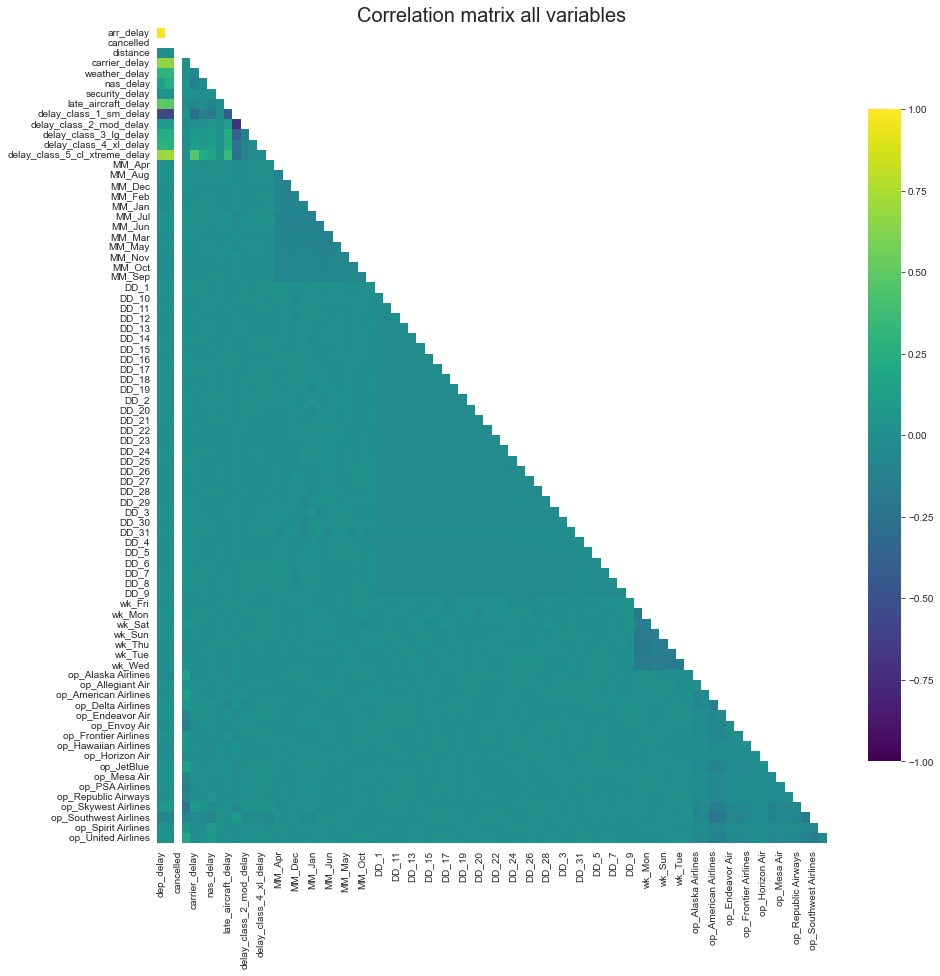

In [190]:
#init mask
mask =np.triu(np.ones_like(delayed_rho, dtype =np.bool_));
sns.set_style('white');
fig, ax = plt.subplots(figsize = (15,15));
#mask adjustment
mask = mask[1:, :-1];
corr = delayed_rho.iloc[1:, :-1].copy();
#heatmap
sns.heatmap(corr, mask =mask, cmap = 'viridis', vmin = -1, vmax= 1, cbar_kws={"shrink": .8});
plt.title('Correlation matrix all variables', size = 20);
plt.savefig(f"../Assets/correl_all_var.pdf", bbox_inches="tight");

In [192]:
flights.isnull().sum().sum()

0

Let's look at groups of variables against only our target, `arr_delay`

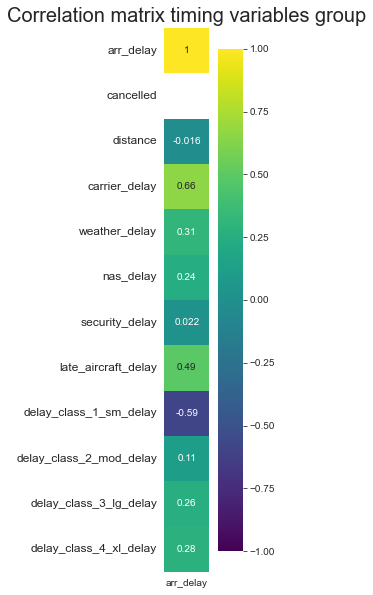

In [193]:
fig, ax = plt.subplots(figsize=(3,10))
#heatmap
sns.heatmap(corr[['arr_delay']][0:12],  annot =True, cmap = 'viridis', vmin = -1, vmax= 1, square = True)
plt.title('Correlation matrix timing variables group', size = 20)

plt.yticks(rotation = 0, fontsize =12)

plt.savefig(f"../Assets/correl_timing_var.pdf", bbox_inches="tight")

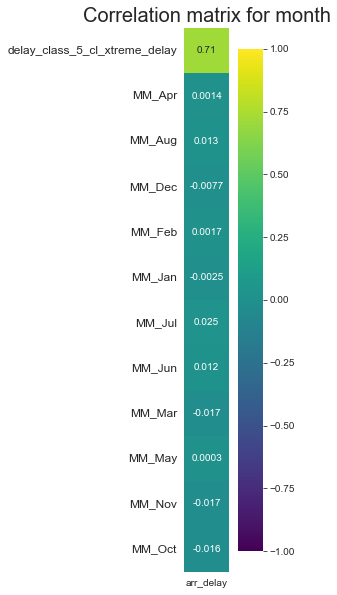

In [194]:
fig, ax = plt.subplots(figsize=(3,10))
#heatmap
sns.heatmap(corr[['arr_delay']][12:24],  annot =True, cmap = 'viridis', vmin = -1, vmax= 1, square = True)
plt.title('Correlation matrix for month', size = 20)

plt.yticks(rotation = 0, fontsize =12)

plt.savefig(f"../Assets/correl_Month_var.pdf", bbox_inches="tight")

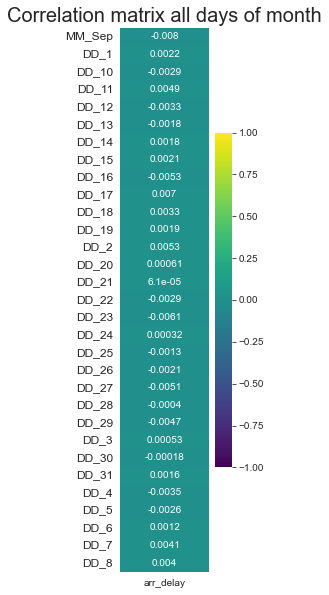

In [195]:
fig, ax = plt.subplots(figsize=(2,10))
#heatmap
sns.heatmap(corr[['arr_delay']][24:55],  annot =True, cmap = 'viridis', vmin = -1, vmax= 1, square = False)
plt.title('Correlation matrix all days of month', size = 20)

plt.yticks(rotation = 0, fontsize =12)
plt.savefig(f"../Assets/correl_timing_DD_var.pdf", bbox_inches="tight")

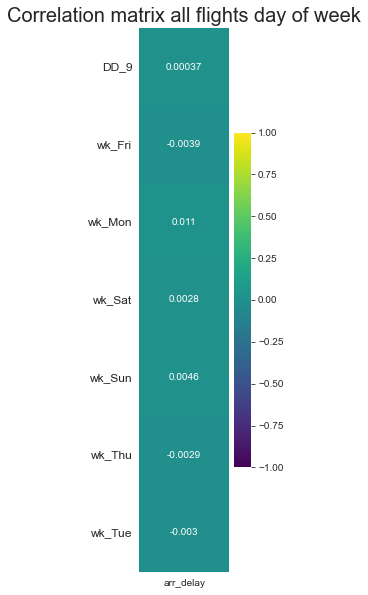

In [196]:
fig, ax = plt.subplots(figsize=(2,10))
#heatmap
sns.heatmap(corr[['arr_delay']][55:62],  annot =True, cmap = 'viridis', vmin = -1, vmax= 1, square = False)
plt.title('Correlation matrix all flights day of week', size = 20)

plt.yticks(rotation = 0, fontsize =12)
plt.savefig(f"../Assets/correl_WK_var.pdf", bbox_inches="tight")

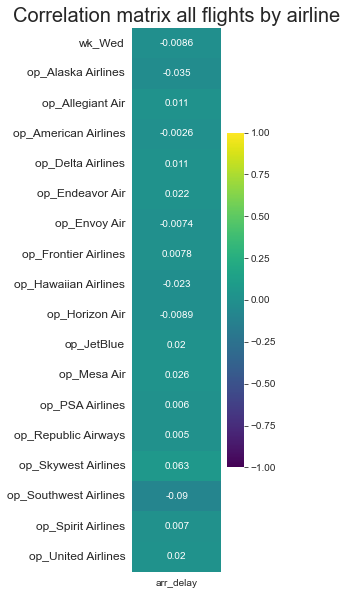

In [197]:
fig, ax = plt.subplots(figsize=(2,10))
#heatmap
sns.heatmap(corr[['arr_delay']][62:],  annot =True, cmap = 'viridis', vmin = -1, vmax= 1, square = False)
plt.title('Correlation matrix all flights by airline', size = 20)

plt.yticks(rotation = 0, fontsize =12)
plt.savefig(f"../Assets/correl_operator_var.pdf", bbox_inches="tight")

With the current collection of correlation analysis, it does not appear that features will be selected based on Pearson correlation values. 
The final dimension to examine would be airports. 

In [ ]:
### add refactored content from III to here. 

## Feature Engineering: airport dummy values
---
Let's revisit the airport markets column that generated a pair of origin - destination city pairs.  

In [198]:
flights['markets'].nunique()

7504

In [199]:
flights['origin'].nunique()

381

In [200]:
flights['dest'].nunique()

380

It looks as though we had found one flight where a flight was operated to a place but not from a place. 

It is possible that our sampling method picked up an inbound flight and no outbound flights for this airport. After some additional research, I found that I could use sklearns OHE that converts my markets column to a sparse matrix to save some memory. I will try it here

In [204]:
#test = flights.copy()

In [205]:
#from sklearn.preprocessing import OneHotEncoder

Holding off for now since this still needs to be modeled and tested 2x

In [203]:
flights.to_csv('flights_processed_w_dummies.csv', index = False)


# End of Notebook II.
----
Thank you for reviewing my code notebook for flight delay predictions. We are getting close to running a model and we will do so (a few times!!) in Notebook III

In [202]:
flights.isnull().sum().sum()

0

In [233]:
#save copy of cleaned sample dataframe without dummies transformations.
flights.to_csv('flights_processed_ex_dummies.csv', index = False)